# Go-Bike Data Exploration
## by Jiwoon Kim

## Preliminary Wrangling

> Ford GoBike is the Bay Area's new bike share system. (The name of this service/app had been changed to 'LYFT')  
The dataset(s) provided to us by Ford contain the following fields:  
 - User Type (Subscriber or Customer)
 - Member Birth year 
 - Member Gender
 - Bike ID
 - Duration Seconds  
 - Start Time
 - End Time
 - Station Latitude
 - Station Longitude
 - Station ID
 - Station Name
 
> I'll use the data from Jan 2017 to Apr 2019 , as their columns or attributes are almost identical. (after May 2019, the file name changed , so did the columns)

In [1]:
# import all packages and set plots to be embedded inline
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from geopy.distance import geodesic
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

#### Loading Data (It's been changed to comment for convenient iteration , I skiped the explaination for download data)

In [2]:
# saving data from website
# I won't use the data of 'baywheel' as this have columns different form others

# creating new folder for saved data
folder_name = 'csvdata'

if not path.exists(folder_name):
    makedirs(folder_name)

# saving 2017 year data
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_name))

In [3]:
# saving 2018 year data


for month in range(1,13):
    month_str = str(month)
    month_zero_fill = month_str.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_zero_fill + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(folder_name)

In [4]:
# saving 2019 year data , last one is may

for month in range(1,5):
    month_str = str(month)
    month_zero_fill = month_str.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2019' + month_zero_fill + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(folder_name)


In [5]:
# listdir(folder_name)

In [6]:
# making list of all csv file togather 
list_csvs = []
for csvfile in listdir(folder_name):
    if str(csvfile).endswith('csv'):
        list_csvs.append(folder_name+'/'+csvfile)
    else :
        continue;

In [7]:
df_list = []
for csv in list_csvs :
    df_list.append(pd.read_csv(csv, delimiter = ','))

In [8]:
df = pd.concat(df_list)
# df = df.drop(columns='Unnamed: 0')
# df.to_csv('bike_data_org.csv')

In [9]:
# df = pd.read_csv('bike_data_org.csv' , index_col = 0)

#### Cleaning data

In [10]:
df.shape

(3254325, 16)

In [11]:
#creating 'member age' column from 'member_birth_year' column
df['member_age'] = 2020 - df.member_birth_year

In [12]:
df = df.sort_values(by='start_time').reset_index(drop=True)

In [13]:
# Creating coordinate data from start & end point
df['end_coordinate'] = list(zip(df.end_station_latitude , df.end_station_longitude))
df['start_coordinate'] = list(zip(df.start_station_latitude , df.start_station_longitude))

In [14]:
# find distance between start and end point using geopy library
df['distance_km'] = df.apply(lambda x : geodesic(x['start_coordinate'],x['end_coordinate']).km , axis = 1)

In [15]:
# convert into timestamp data type
df['end_time'] = pd.to_datetime(df['end_time'])
df['start_time'] = pd.to_datetime(df['start_time'])

In [16]:
# creating columns related to time
df['start_dow'] = df['start_time'].dt.day_name()
df['month'] = df['start_time'].dt.month
df['year'] = df['start_time'].dt.year

In [17]:
# combining year with month to observe montly trend
df['year_month'] = df['year'].astype(str) + '-'+ df['month'].astype('str').str.zfill(2)

In [18]:
df.head(10)

,bike_id,bike_share_for_all_trip,duration_sec,end_station_id,end_station_latitude,end_station_longitude,end_station_name,end_time,member_birth_year,member_gender,...,start_time,user_type,member_age,end_coordinate,start_coordinate,distance_km,start_dow,month,year,year_month
0,240,NaN,424,48.0,37.782411,-122.392706,2nd St at S Park St,2017-06-28 09:54:41.187,1985.0,Female,...,2017-06-28 09:47:36.347,Subscriber,35.0,"(37.782411189735896, -122.39270595839115)","(37.7896254, -122.400811)",1.072791,Wednesday,6,2017,2017-06
1,669,NaN,366,59.0,37.774814,-122.418954,S Van Ness Ave at Market St,2017-06-28 09:53:47.715,1981.0,Male,...,2017-06-28 09:47:41.664,Subscriber,39.0,"(37.774814, -122.418954)","(37.776619000000004, -122.41738500000001)",0.243400,Wednesday,6,2017,2017-06
2,117,NaN,188,48.0,37.782411,-122.392706,2nd St at S Park St,2017-06-28 09:52:55.338,1984.0,Male,...,2017-06-28 09:49:46.377,Subscriber,36.0,"(37.782411189735896, -122.39270595839115)","(37.78752178045625, -122.39740490913393)",0.702203,Wednesday,6,2017,2017-06
3,77,NaN,1201,9.0,37.798572,-122.400869,Broadway at Battery St,2017-06-28 10:11:00.359,1985.0,Male,...,2017-06-28 09:50:59.175,Subscriber,35.0,"(37.79857210846257, -122.40086898207666)","(37.77588, -122.39317)",2.608357,Wednesday,6,2017,2017-06
4,316,NaN,431,321.0,37.780146,-122.403071,5th at Folsom,2017-06-28 10:03:51.090,1973.0,Male,...,2017-06-28 09:56:39.631,Subscriber,47.0,"(37.78014570345598, -122.40307085237872)","(37.77874161153677, -122.39274082710837)",0.923270,Wednesday,6,2017,2017-06
5,605,NaN,1086,90.0,37.771058,-122.402717,Townsend St at 7th St,2017-06-28 10:15:02.469,1958.0,Male,...,2017-06-28 09:56:55.488,Subscriber,62.0,"(37.771058000000004, -122.402717)","(37.795392, -122.394203)",2.803088,Wednesday,6,2017,2017-06
6,272,NaN,730,44.0,37.781074,-122.411738,Civic Center/UN Plaza BART Station (Market St ...,2017-06-28 10:10:44.213,1980.0,Male,...,2017-06-28 09:58:33.669,Subscriber,40.0,"(37.7810737, -122.4117382)","(37.79146400000001, -122.391034)",2.157799,Wednesday,6,2017,2017-06
7,400,NaN,435,45.0,37.781752,-122.405127,5th St at Howard St,2017-06-28 10:08:10.438,1991.0,Male,...,2017-06-28 10:00:54.528,Subscriber,29.0,"(37.781752000000004, -122.40512700000001)","(37.77588, -122.39317)",1.238685,Wednesday,6,2017,2017-06
8,212,NaN,590,22.0,37.789756,-122.394643,Howard St at Beale St,2017-06-28 10:10:49.486,1983.0,Male,...,2017-06-28 10:00:59.041,Subscriber,37.0,"(37.789756, -122.39464299999999)","(37.77874161153677, -122.39274082710837)",1.233943,Wednesday,6,2017,2017-06
9,915,NaN,553,50.0,37.780526,-122.390288,2nd St at Townsend St - Coming Soon,2017-06-28 10:18:20.411,1973.0,Male,...,2017-06-28 10:09:06.498,Subscriber,47.0,"(37.780526, -122.39028799999998)","(37.795392, -122.394203)",1.685666,Wednesday,6,2017,2017-06


In [1]:
# #Saving 
# # df.to_pickle('df_clean_0524.pkl')
# df_org = pd.read_pickle('df_clean_0524.pkl')
# df = df_org.copy()

In [3]:
df.columns

Index(['bike_id', 'bike_share_for_all_trip', 'duration_sec', 'end_station_id',
       'end_station_latitude', 'end_station_longitude', 'end_station_name',
       'end_time', 'member_birth_year', 'member_gender', 'start_station_id',
       'start_station_latitude', 'start_station_longitude',
       'start_station_name', 'start_time', 'user_type', 'member_age',
       'end_coordinate', 'start_coordinate', 'distance_km', 'start_dow',
       'month', 'year', 'year_month'],
      dtype='object')

In [4]:
# Selecting columns I'm interested in
df = df[['bike_id','distance_km','duration_sec','member_gender','user_type','member_age','start_dow','year_month','month','year','start_time','start_station_name']]

In [5]:
df.sample(5)

,bike_id,distance_km,duration_sec,member_gender,user_type,member_age,start_dow,year_month,month,year,start_time,start_station_name
2555953,5227,0.000000,2137,Male,Subscriber,32.0,Tuesday,2019-01,1,2019,2019-01-29 20:01:53.922,Union Square (Powell St at Post St)
705883,3641,2.179723,763,NaN,Customer,NaN,Saturday,2018-02,2,2018,2018-02-24 12:20:12.614,Powell St BART Station (Market St at 4th St)
137888,155,3.095704,1503,NaN,Customer,NaN,Monday,2017-09,9,2017,2017-09-04 13:16:38.071,Mission Playground
718288,467,2.139049,754,Female,Subscriber,39.0,Wednesday,2018-02,2,2018,2018-02-28 09:20:54.880,Beale St at Harrison St
2079947,4417,3.383369,846,Male,Subscriber,35.0,Thursday,2018-10,10,2018,2018-10-25 18:01:56.455,Powell St BART Station (Market St at 4th St)


#### What is the structure of your dataset?

There are 4,740,302 of bike use record in this dataset with 16 features. \
This dataset came from seperate 24 csv file. 

Datatypes are mixed with numeric,date and object :
  - numeric : bike_id , duration_sec , distance_km, member_age 
  - object : member_gender , start_station_name , end_station_name , start_dow , end_dow 
  - datetime : start_time, end_time

### What is/are the main feature(s) of interest in your dataset?
- My focus is what makes people use more and longer about this service
- So, I'm interested in figuring out the best factors which influence the __trip duration__ and __usage__  

### What features in the dataset do you think will help support your investigation into your feature of interest? 
- User's charateristics(Age, Gender, Type) , Day of week of use ,  Time siries

## Univariate Exploration

Let's start looking into each variable I'm focusing on.

#### Duration of ride 

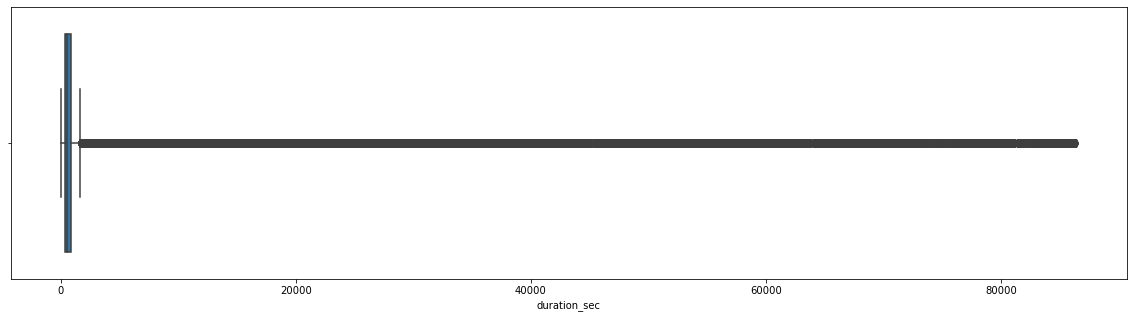

In [6]:
plt.subplots(figsize=(20,5))
sns.boxplot(data = df, x = 'duration_sec', orient = 'h' )

It seems that there's lot of data out of box. I'd like to focus average level , so I use the data under 4000 second only. Otherwise, It took too long time to query as my PC is not good enough.  

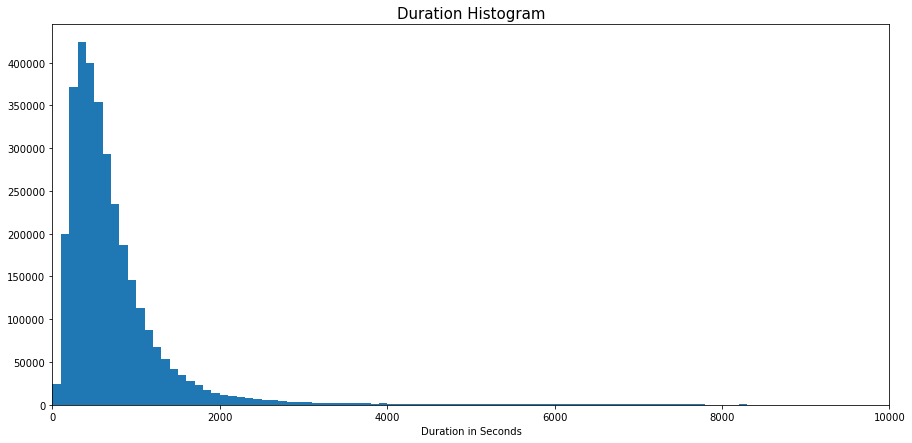

In [7]:
plt.figure(figsize=(15,7))
bin_edges = np.arange(0, 10000,100)
plt.xlim(0, 10000);
plt.hist(data = df, x = 'duration_sec' , bins = bin_edges)
plt.title('Duration Histogram', fontsize = 15);
plt.xlabel('Duration in Seconds');

As the long tail is observed, so I did transformation into log scale on it.

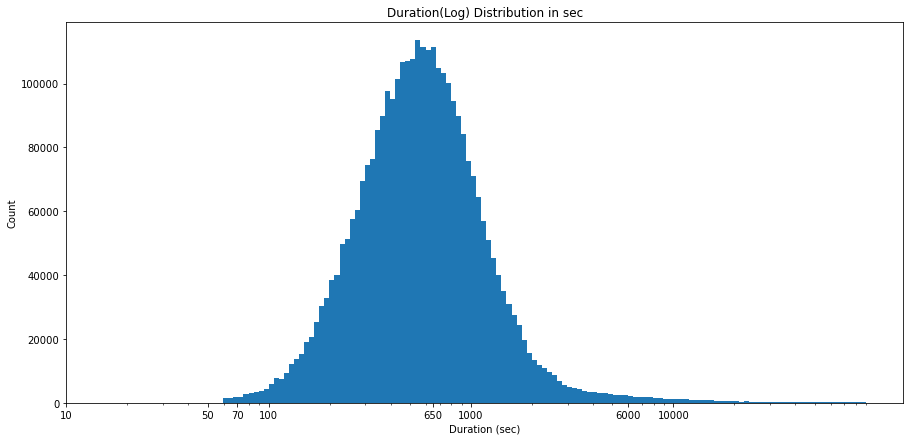

In [8]:
# Log scale plot
log_binsize = 0.025
bin_edges_log = 10 ** np.arange(1.2, np.log10(df['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=(15,7))
plt.hist(data = df, x = 'duration_sec', bins = bin_edges_log)
plt.xscale('log')
plt.xticks([10,50,70,100,650,1000,6000,10000], [10,50,70,100,650,1000,6000,10000])
plt.xlabel('Duration (sec)')
plt.ylabel('Count')
plt.title('Duration(Log) Distribution in sec');

It looks like right skewed before transformation.
Under the log-transformations, It looks like unimodel with one peak between 550 and 650 seconds.

I take duration up to 4000 because its range is too large to explore and data is rare at low figures.

In [9]:
df = df.query("duration_sec <= 4000")

#### Distance of ride 

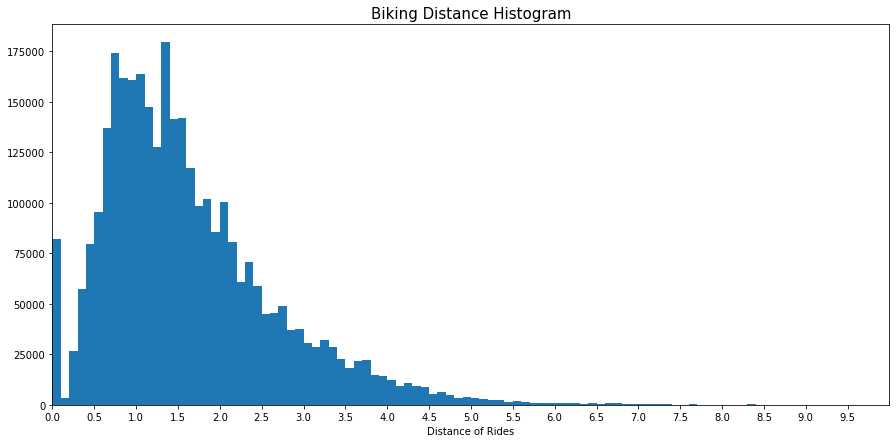

In [10]:
plt.figure(figsize=(15,7))
bin_edges = np.arange(0, 10,0.1)
plt.xlim(0, 10);
plt.hist(data = df, x = 'distance_km' , bins = bin_edges)
plt.xticks(np.arange(0,10,0.5))
plt.title('Biking Distance Histogram', fontsize = 15);
plt.xlabel('Distance of Rides');

It is rigth-skewed plot.
Those data are observed a lot around 1KM.

I make the data left only under 10KM for looking into only major case

In [11]:
df = df.query("distance_km <= 10")

#### Age of users

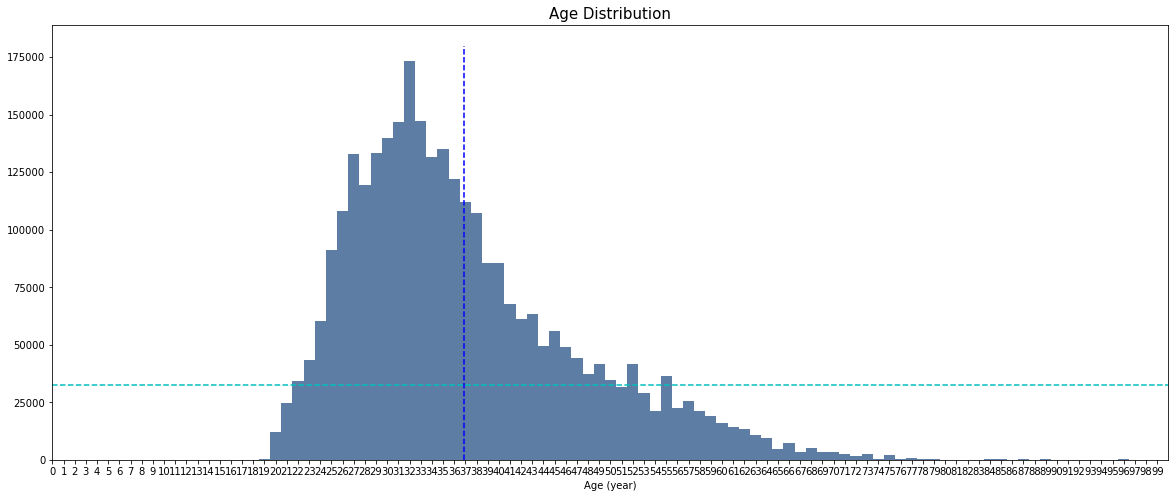

In [12]:
bin_size = 1
bins = np.arange(0, (df.member_age.max())+bin_size, bin_size)
color = sns.color_palette('viridis')[1]

plt.subplots(figsize = (20,8))
plt.hist(df.member_age, bins = bins, color= color, align="left", alpha=0.8)
plt.xticks(ticks = [x for x in range(0,100,1)])
plt.xlim((0,100))
plt.title('Age Distribution', size=15)
plt.xlabel('Age (year)')
plt.hlines(df.member_age.value_counts().mean(), 0, 100, colors = "c", linestyles = "dashed")
plt.vlines(df.member_age.mean(), 0, 180000,colors = "b", linestyles = "dashed")

In [13]:
df = df.query("17<= member_age <= 80")

#### Age group of users

To understand easily, I splited the age into 6 groups :   
10's , 20's, 30's, 40's, 50's and over 60 years.

In [14]:
#Generate a new column member_age_bins from member age group
df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60  
                                                  else '60 - 80')

In [15]:
age_order =  ['10 - 20' , '20 - 30' , '30 - 40' , '40 - 50' ,'50 - 60' , '60 - 80'] 

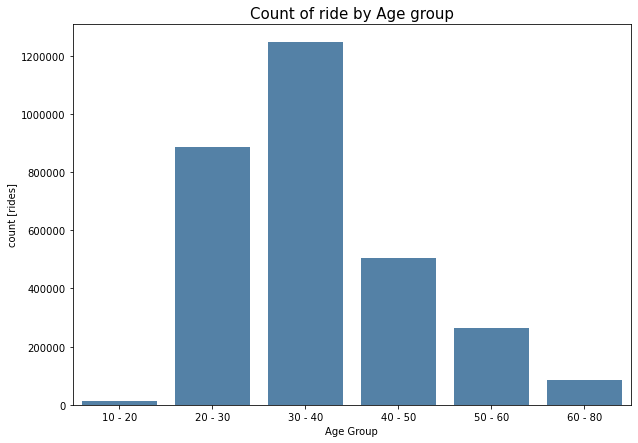

In [16]:
plt.subplots(figsize = (10,7))
sns.countplot(x='member_age_bins' , color = 'steelblue' , data = df , order= age_order)
plt.title('Count of ride by Age group', size=15)
plt.xlabel('Age Group')
plt.ylabel('count [rides]')
plt.ticklabel_format(style = 'plain' , axis = 'y')

I can see the Thirties is major user of this service

#### Montly Demand Trend

Text(0, 0.5, 'count [rides]')

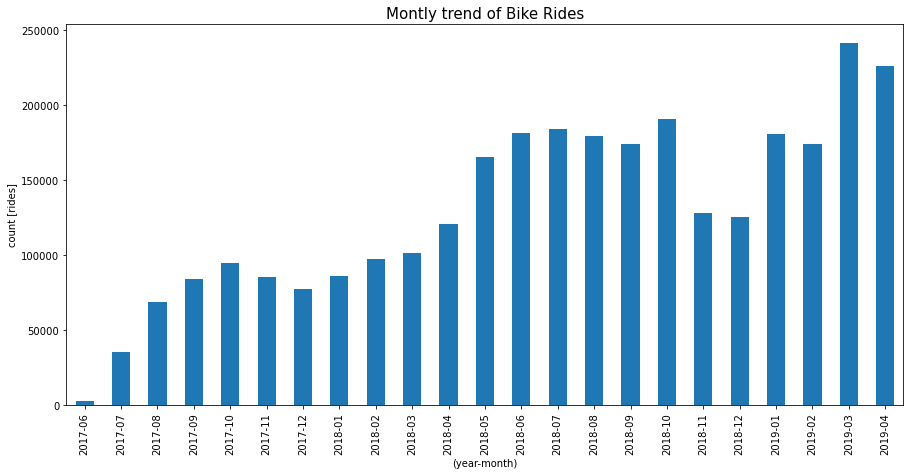

In [17]:
plt.figure(figsize = (15, 7))
df.groupby(df.year_month)['bike_id'].count().plot(kind="bar")
plt.title('Montly trend of Bike Rides'  , fontsize = 15)
plt.xlabel('(year-month)')
plt.ylabel('count [rides]')

The general trend of it's growth is noticable.   
What's unusual is that demand has dropped pretty a lot for a while in November 2018 for two month.

#### Montly Duration Trend

Text(0, 0.5, 'Avg.Duration [sec]')

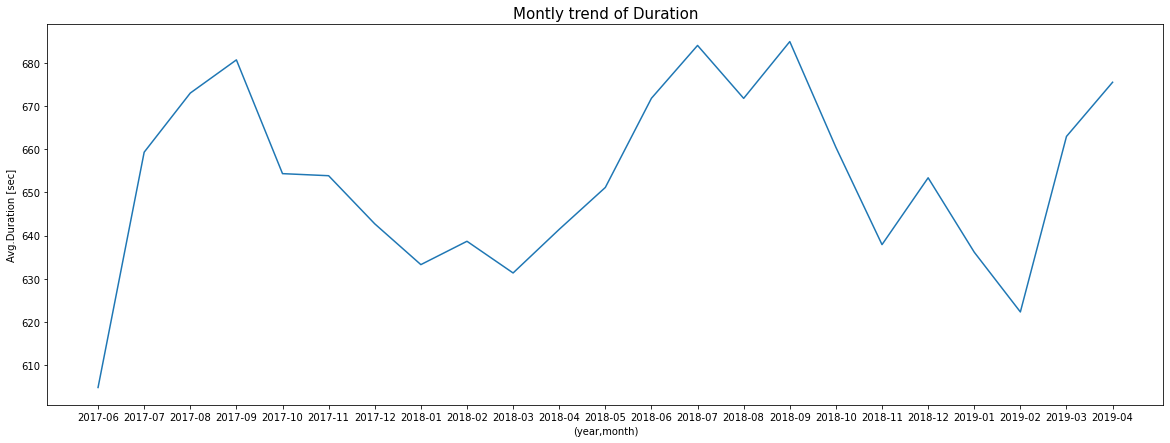

In [18]:
temp = df.groupby(df.year_month)['duration_sec'].agg('mean')
plt.figure(figsize = (20, 7))
sns.lineplot(x= temp.index , y = temp.values)
plt.title('Montly trend of Duration'  , fontsize = 15)
plt.xlabel('(year,month)')
plt.ylabel('Avg.Duration [sec]')

While the usage is increasing over time , but average duration of riding isn't.  
It may have relationship with seasonality , when we see the dip between October and Feburary of the following year.

#### Bike rides usage Per Weekday

Text(0, 0.5, 'count [rides]')

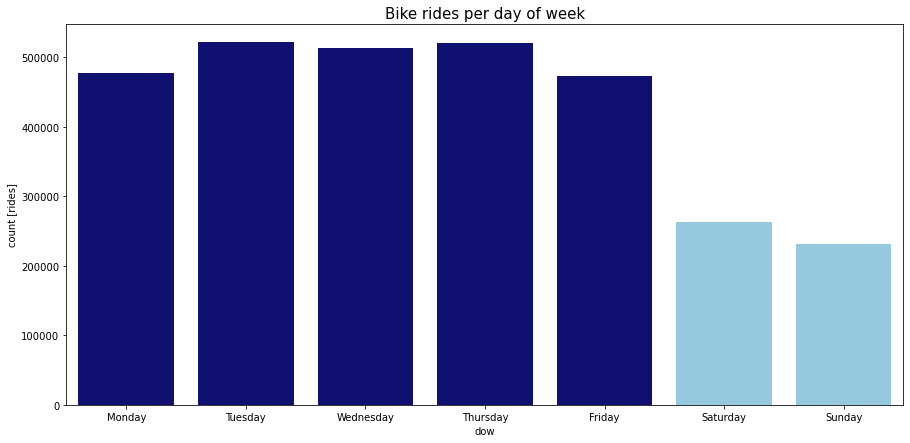

In [19]:
dow_order = ['Monday', 'Tuesday' ,'Wednesday', 'Thursday' ,'Friday' ,'Saturday' ,'Sunday']
plt.figure(figsize = (15, 7))
color_dow = ['navy'] *5  + ['skyblue'] *2
sns.countplot(x="start_dow", data=df, order=dow_order ,palette= color_dow)
plt.title('Bike rides per day of week' , fontsize = 15)
plt.xlabel('dow')
plt.ylabel('count [rides]')

Bike is used more on weekday compared to weekend.  
It looks like Bike sharing is used mostly between Monday to Friday weekdays when compare to weekends.This may be due to people are accessing for daily commute to workplace and schools etc.

#### Bike rides per hour in a day

Text(0, 0.5, 'Count[rides]')

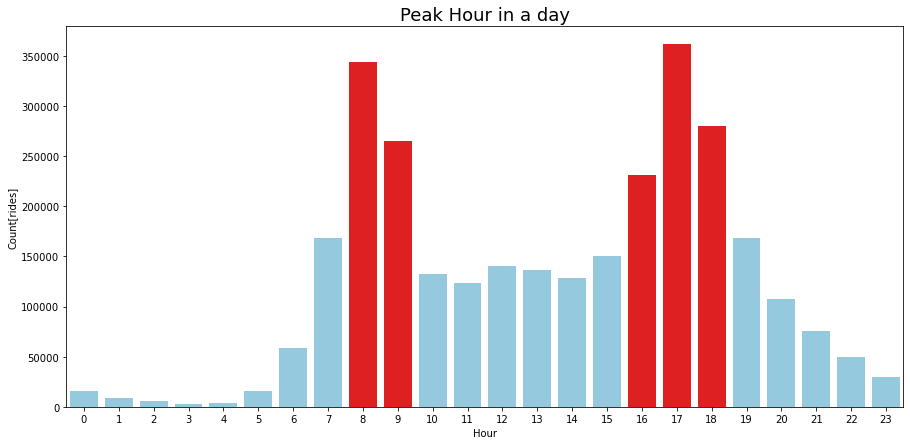

In [20]:
values = df.start_time.dt.hour.value_counts().sort_index()
rank5 = values[values.rank(ascending= False) == 5]
clrs = ['skyblue' if (x < rank5.values) else 'red' for x in values]
plt.figure(figsize = (15, 7))
sns.countplot(df.start_time.dt.hour , palette=clrs)

plt.title('Peak Hour in a day', fontsize = 18)
plt.xlabel('Hour')
plt.ylabel('Count[rides]')

The red bar is showing the top-5 peak hour in a day.  
In the similar vein to day of week above, people use the serivce for the commute as the peak hour seems to same as usual rush hour. 


#### Bike rides per gender

Text(0, 0.5, 'Count[rides]')

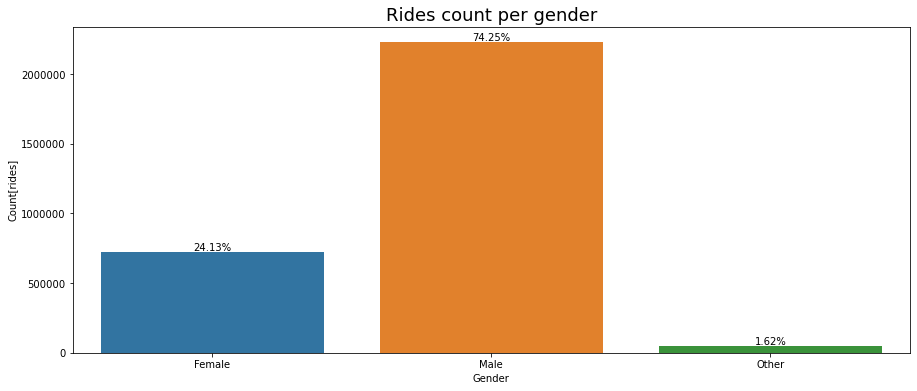

In [21]:
plt.figure(figsize = (15, 6))
ax = sns.countplot(df.member_gender)
total = len(df.member_gender)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2 , height+10000 , '{:.2%}'.format(height/total) , ha = 'center')

plt.ticklabel_format(style = 'plain' , axis = 'y')
plt.title('Rides count per gender', fontsize = 18)
plt.xlabel('Gender')
plt.ylabel('Count[rides]')

The graph show that main customer base is Male , rather than Female and Others.

#### Bike rides per User Type

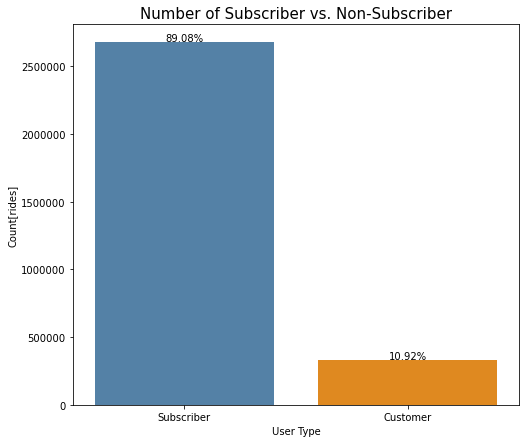

In [22]:
plt.figure(figsize = (8, 7))
ax = sns.countplot(df.user_type , palette=['steelblue','darkorange'])
total = len(df.user_type)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2 , height+10000 , '{:.2%}'.format(height/total) , ha = 'center')
plt.title('Number of Subscriber vs. Non-Subscriber', fontsize = 15);
plt.ticklabel_format(style = 'plain' , axis = 'y')
plt.xlabel('User Type')
plt.ylabel('Count[rides]');

The number of usage by subscriber is much higher than by customer(non-subsriber)

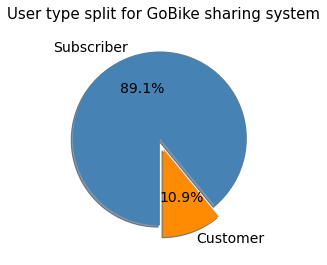

In [23]:
customer = df.query('user_type == "Customer"')['bike_id'].count()
subscriber = df.query('user_type == "Subscriber"')['bike_id'].count()

customer_proportion = customer / df['bike_id'].count()
subscriber_proportion = subscriber / df['bike_id'].count()

labels = ['Customer', 'Subscriber']
sizes = [customer_proportion, subscriber_proportion]
colors = ['darkorange','steelblue']
explode = (0, 0.13)

plt.pie(sizes, explode=explode, labels=labels,
        autopct='%1.1f%%', shadow=True, startangle=270 , colors = colors , textprops={'fontsize': 14})

plt.title('User type split for GoBike sharing system', size=15 , y= 1.07);

I ploted again as a pie-chart .

#### Proportion of rides per user type

In [24]:
sub_count = df[df.user_type=='Subscriber'].groupby([df['start_time'].dt.year, df['start_time'].dt.month])['bike_id'].count()

In [25]:
sub_pct = sub_count / df.groupby([df['start_time'].dt.year, df['start_time'].dt.month])['bike_id'].count()

In [26]:
sub_pct = sub_pct * 100

In [27]:
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2 , height+10000 , '{:.2%}'.format(height/total) , ha = 'center')

Text(0, 0.5, 'Subscribers(Pecentage)')

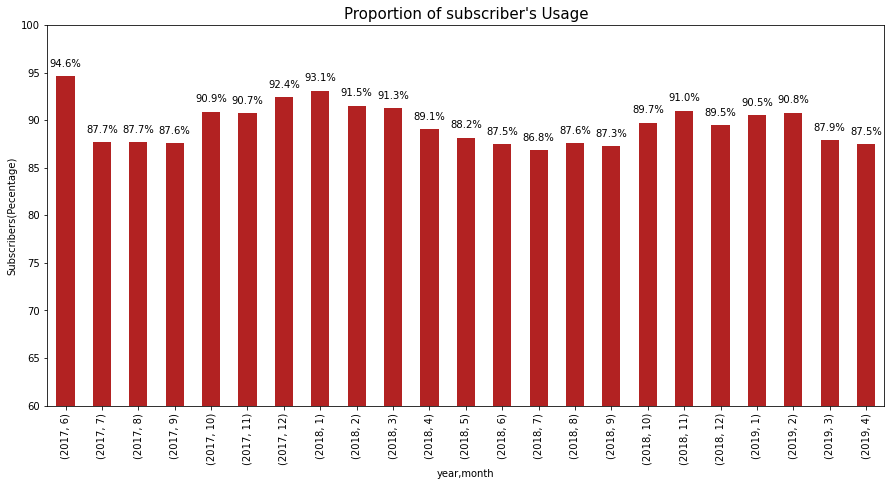

In [28]:
# fig,ax = plt.subplot(figsize=(10,5))
fig, ax = plt.subplots(figsize = (15,7))
# ax.bar(x = np.arange(0,sub_pct.shape[0]), height = sub_pct.shape[0] *[100] , alpha = 0.3)
sub_pct.plot(kind='bar', ax = ax , color = 'firebrick')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2 , height+1 , '{:.1f}'.format(height)+'%' , ha = 'center')
ax.set_ylim(60,100)
ax.set_title('Proportion of subscriber\'s Usage' , size= 15)
ax.set_xlabel('year,month')
ax.set_ylabel('Subscribers(Pecentage)')

We can see that the subscriber usage increased over three months.
In other words,  There was an increase in temporary demand (by non-subscribers) during this period.

#### Most famous station

In [29]:
start_st_30 = df.start_station_name.value_counts()
start_st_30 = start_st_30[:30]

Text(0.5, 0, 'Count')

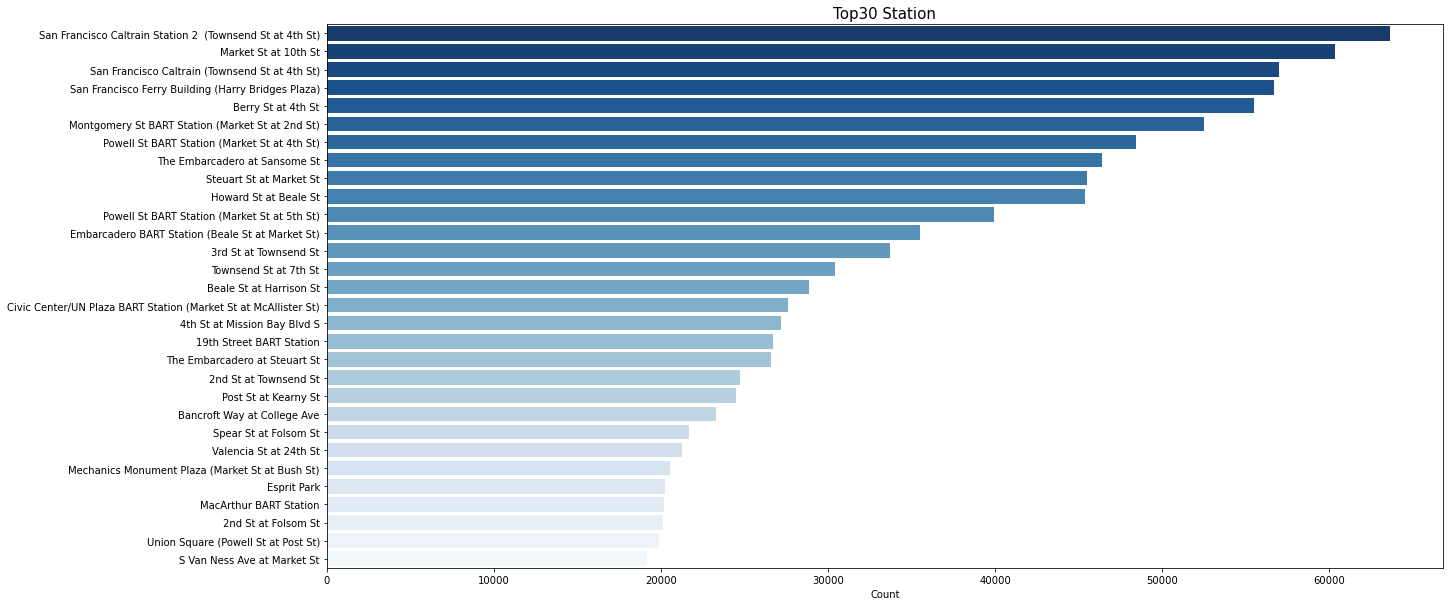

In [30]:
plt.subplots(figsize = (20,10))
sns.barplot(y=start_st_30.index, x = start_st_30, orient='h',palette='Blues_r')
plt.title('Top30 Station', size=15)
plt.xlabel('Count')

This graph show the Top 30 start station in use-frequency

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The duration has a very larege range of data and It is right-skewed. So I get it to be log-sclaed and found that it took shape as unimodel with one peak between 550 and 650 seconds.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I generated "Age" by subtracting birth year and present year(2020) and got rid of more than 80. Then I also divided it into groups.
I get distribution of age and group of its, so that I can understand better about users charateristics rather than birth year itself.  

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

#### Day of week & User Type

In [31]:
grp1 = df.groupby(['user_type','start_dow'])['bike_id'].count()
grp2 = grp1.groupby(level=0).apply(lambda x: round(100 * x / x.sum()))
grp2 = grp2.reset_index()

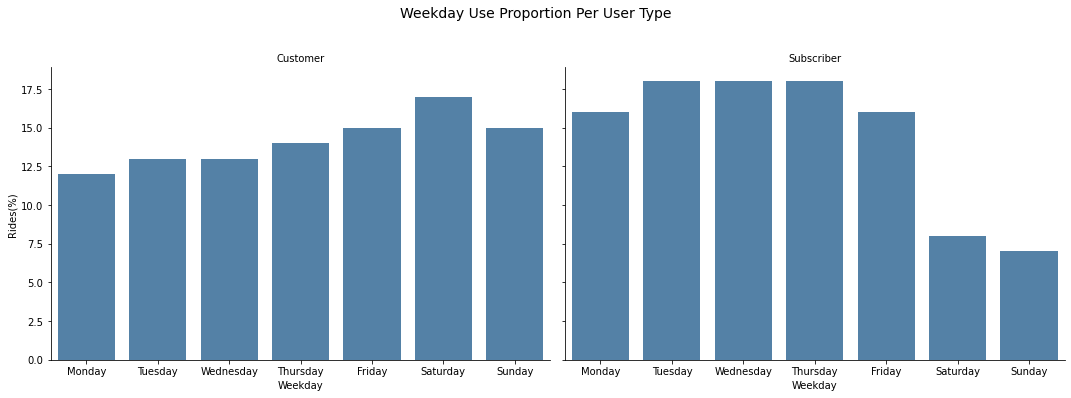

In [32]:
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# fig,ax= plt.subplots(1,2,figsize = (10,10))
g = sns.catplot(data= grp2 , x='start_dow' ,y='bike_id', kind='bar' ,col='user_type' ,order = dow_order , color = 'steelblue' , height=5 ,aspect=1.5)
g.set_axis_labels("Weekday", "Rides(%)")
g.set_titles("{col_name}")
g.fig.suptitle('Weekday Use Proportion Per User Type', y=1.1, fontsize=14);

From this bar graph, we can figure out the difference between customers and subscribers.  
Customers tend to use more on weekends, while subscribers do more on weekdays or workingday.

#### Day of week & Gender

In [33]:
gen1 = df.groupby(['member_gender','start_dow'])['bike_id'].count()
gen2 = gen1.groupby(level=0).apply(lambda x: round(100 * x / x.sum()))
gen2 = gen2.reset_index()

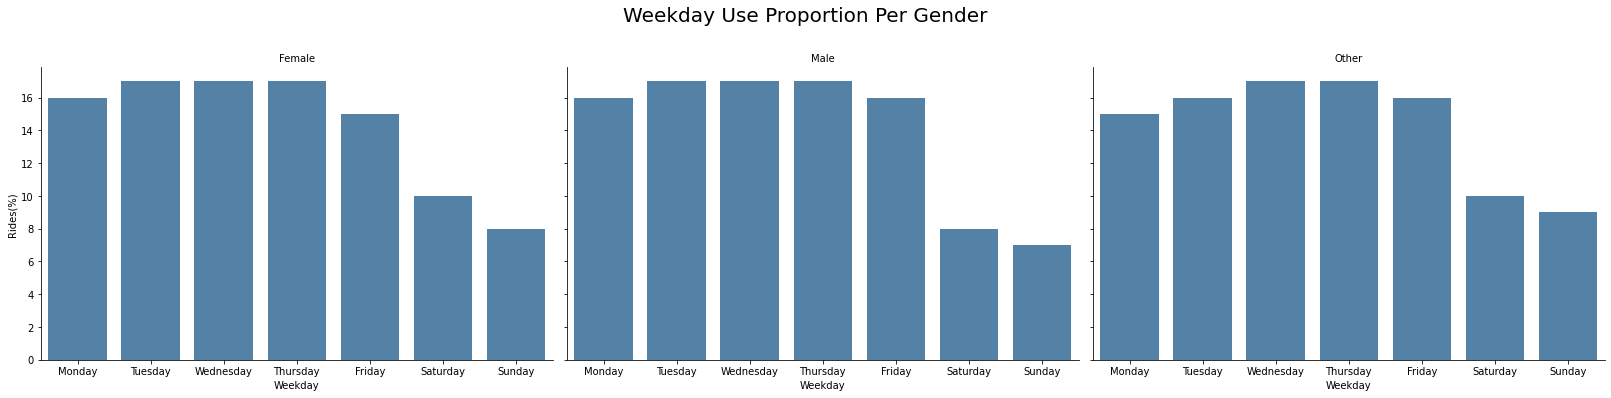

In [34]:
# fig,ax= plt.subplots(1,2,figsize = (10,10))
g = sns.catplot(data= gen2 , x='start_dow' , y='bike_id', kind='bar' ,col='member_gender' ,order = dow_order , color = 'steelblue' , height=5 ,aspect=1.5)
g.set_axis_labels("Weekday", "Rides(%)")
g.set_titles("{col_name}")
g.fig.suptitle('Weekday Use Proportion Per Gender', y=1.1, fontsize=20);

Those trends are similar between female and male's , but the proportion of weekend usage is more higher in case of female user.  

#### Use hour & User Type

Text(0.5, 1.0, 'Customer Usage Per Hour')

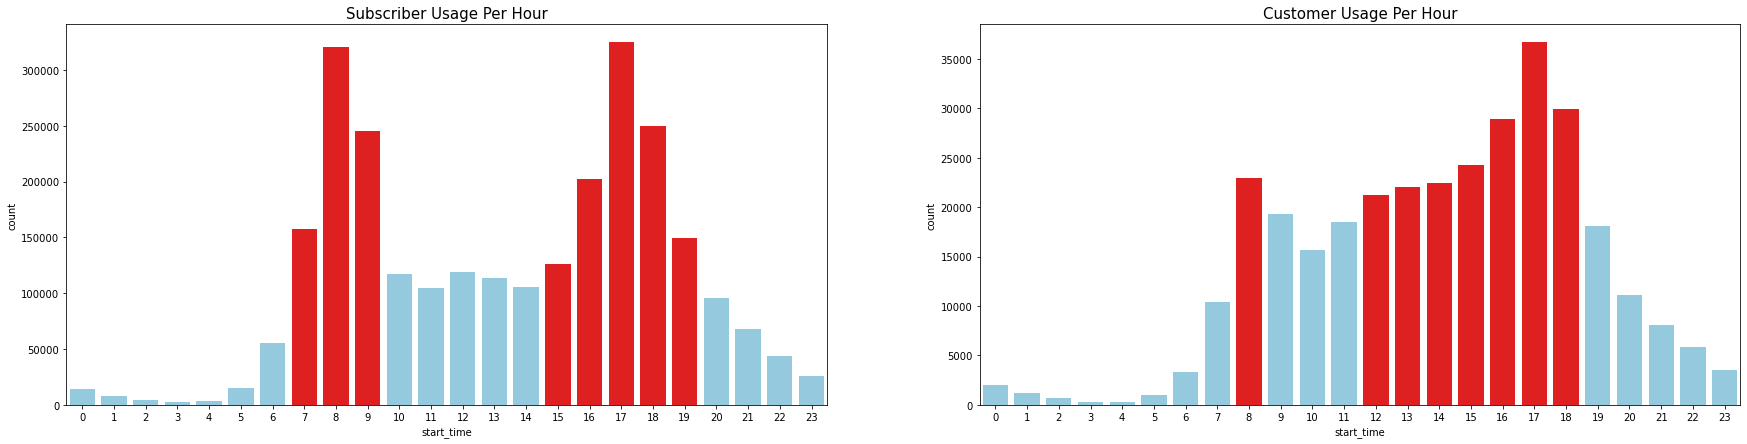

<Figure size 1080x504 with 0 Axes>

In [35]:
fig,ax = plt.subplots(1,2 , figsize = (30, 7))

temp1 = df.query("user_type == 'Subscriber'")
values = temp1.start_time.dt.hour.value_counts().sort_index()
rank5 = values[values.rank(ascending= False) == 8]
clrs = ['skyblue' if (x < rank5.values) else 'red' for x in values]
sns.countplot(temp1.start_time.dt.hour , palette=clrs , ax = ax[0])
ax[0].set_title('Subscriber Usage Per Hour' , fontsize = 15)

temp2 = df.query("user_type == 'Customer'")
values = temp2.start_time.dt.hour.value_counts().sort_index()
rank5 = values[values.rank(ascending= False) == 8]
clrs = ['skyblue' if (x < rank5.values) else 'red' for x in values]
plt.figure(figsize = (15, 7))
sns.countplot(temp2.start_time.dt.hour , palette=clrs , ax = ax[1])
ax[1].set_title('Customer Usage Per Hour' ,fontsize = 15)


The red show the top8 peak hour in a day.  
Customer rent bike more often within the day ,not around usual commute time , compared to subscribers.

#### Duration & User_type

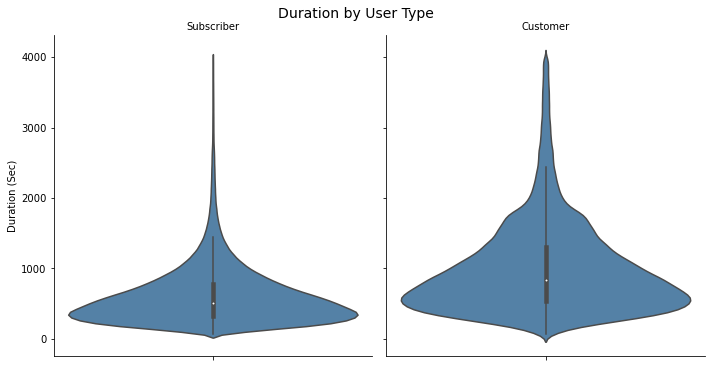

In [36]:
g = sns.catplot(data=df[['duration_sec','user_type']], y='duration_sec', col="user_type", kind='violin', color='steelblue')

g.set_titles(col_template = '{col_name}')
g.set_axis_labels("", "Duration (Sec)")
g.fig.suptitle('Duration by User Type', y=1.01, fontsize=14);

Customers have longer duration of bike trip compare to subscribers' , although the quantity of subscriber's rides is m|uch more higher than customers.   
In my opionion, subscribe use it to commute for short miles whereas customers ride bike for long miles when they enjoy leisure time over a long day relatively.

#### Duration & Gender

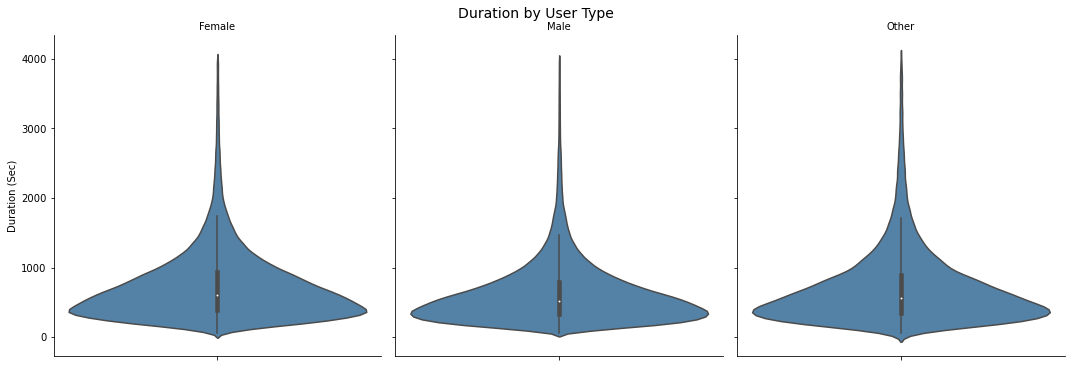

In [37]:
g = sns.catplot(data=df[['duration_sec','member_gender']], y='duration_sec', col="member_gender", kind='violin', color='steelblue')

g.set_titles(col_template = '{col_name}')
g.set_axis_labels("", "Duration (Sec)")
g.fig.suptitle('Duration by User Type', y=1.01, fontsize=14);

Female have longer duration of bike trip compare to Male's , although the quantity of male's rides is much more higher than female's.

#### Duration & Age

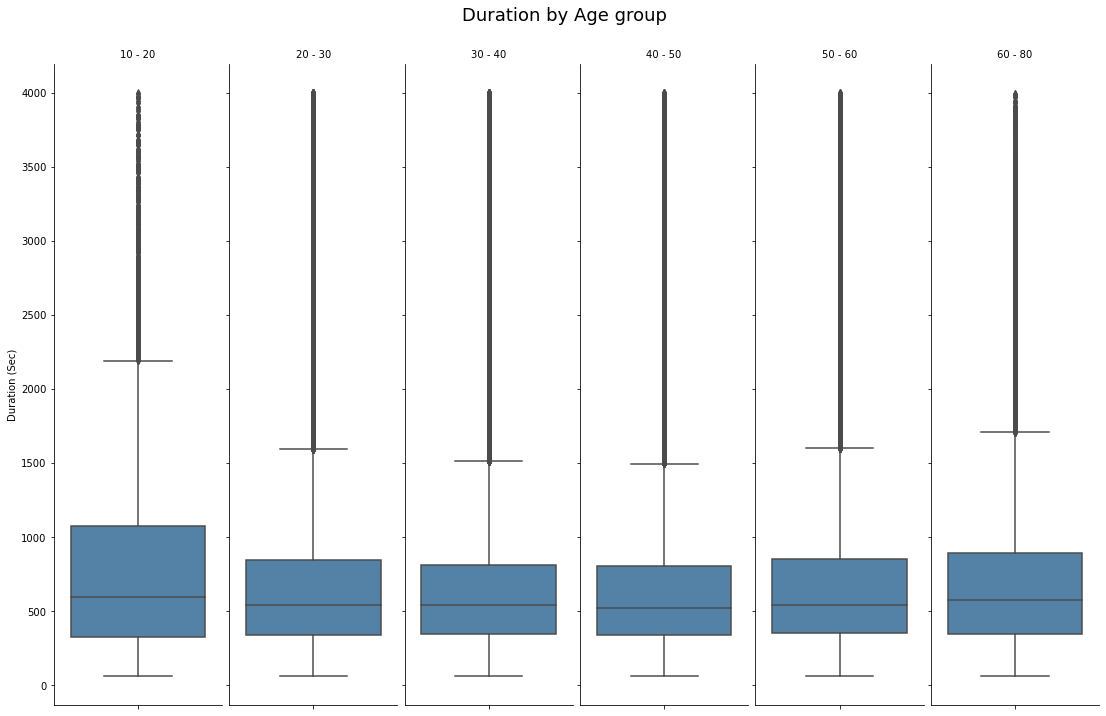

In [38]:
g = sns.catplot(data=df, y='duration_sec', col="member_age_bins", kind='box', color='steelblue',col_order = age_order)

g.set_titles(col_template = '{col_name}')
g.set_axis_labels("", "Duration (Sec)")
g.fig.suptitle('Duration by Age group', y=1.01, fontsize=18)
g.fig.set_size_inches(15,10);

Average duration by each group is all aroud 700 second

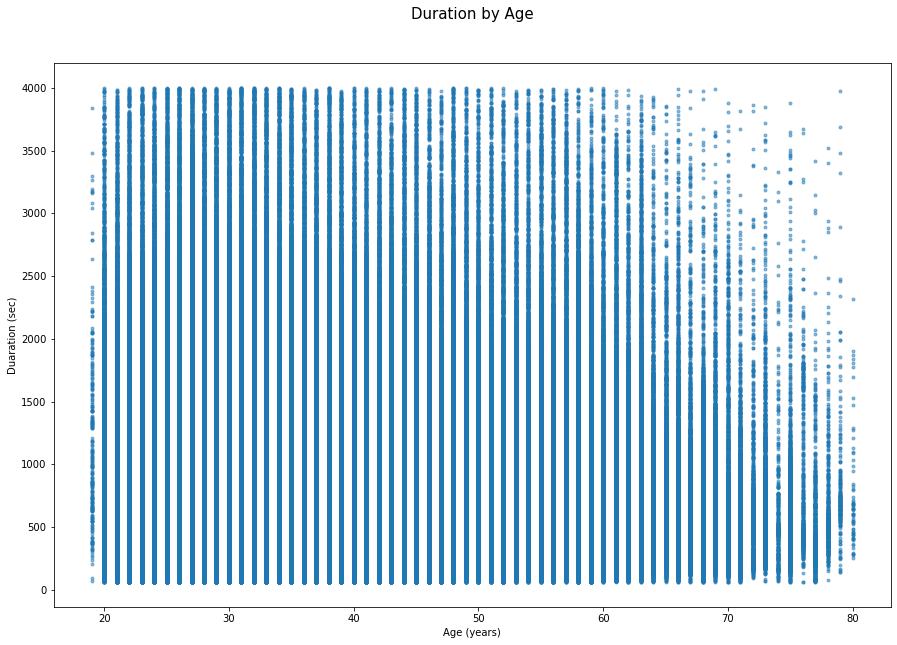

In [39]:
plt.figure(figsize=[15,10])
plt.scatter(df['member_age'], df['duration_sec'], alpha = 0.5, marker = '.' )
# plt.axis([-5, 145, 500, 10500])
plt.xlabel('Age (years)')
plt.ylabel('Duaration (sec)')
plt.title('Duration by Age', size=15 , y= 1.07);

As the age is older, you can see that the points are sparse or rare on high duration area.

#### Bike rides per Age & User type

In [40]:
type_age_group = df.groupby(['member_age_bins' ,'user_type']).size()
type_age_group = type_age_group.groupby(level=0).apply(lambda x: round(100 * x / x.sum(),1)).reset_index()
type_age_group.columns = ['member_age_bins' ,'user_type','count']
type_age_group[type_age_group.user_type=="Subscriber"]

# grp1 = df.groupby(['user_type','start_dow'])['bike_id'].count()
# grp2 = grp1.groupby(level=0).apply(lambda x: round(100 * x / x.sum()))
# grp2 = grp2.reset_index()

,member_age_bins,user_type,count
1,10 - 20,Subscriber,75.1
3,20 - 30,Subscriber,87.0
5,30 - 40,Subscriber,88.9
7,40 - 50,Subscriber,91.0
9,50 - 60,Subscriber,92.2
11,60 - 80,Subscriber,94.2


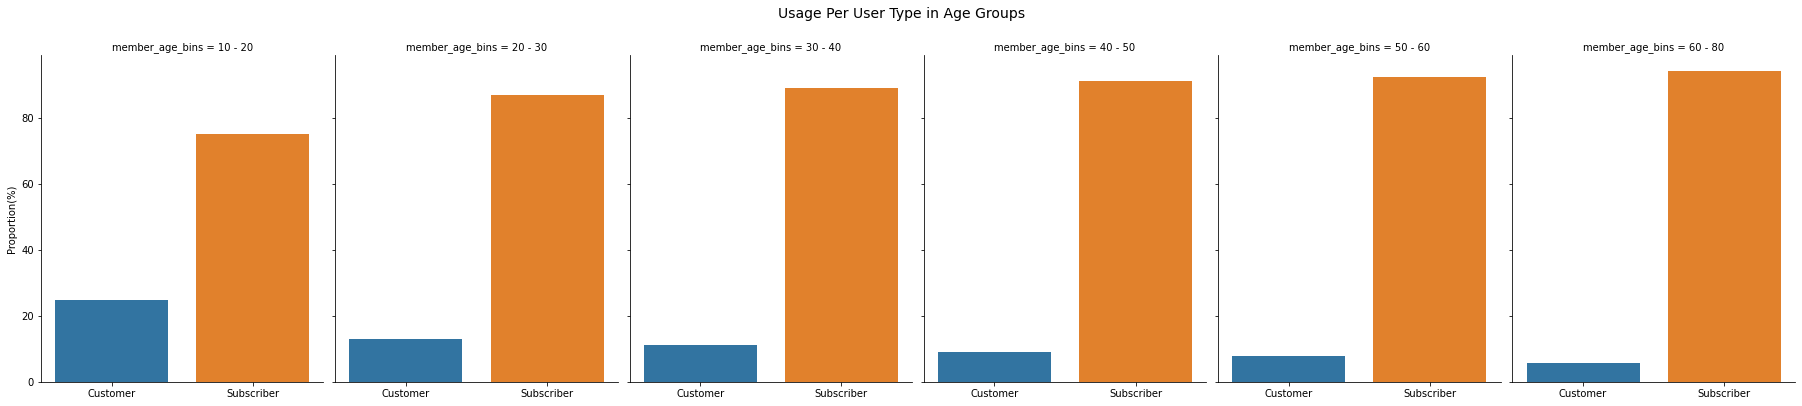

In [41]:
g = sns.catplot(data=type_age_group, x='user_type' , y='count', col="member_age_bins", kind='bar', height=10 ,aspect=0.5)
g.fig.set_size_inches(25,5)
g.set_axis_labels("", "Proportion(%)")
# g.set_titles("{col_name}")
g.fig.suptitle('Usage Per User Type in Age Groups ', y=1.1, fontsize=14);

The proportion of subscriber is higher in older age group than younger group. 

#### Bike rides per Gender & User type

In [42]:
type_gender = df.groupby(['member_gender' ,'user_type']).size()
type_gender = type_gender.groupby(level=0).apply(lambda x: round(100 * x / x.sum(),1)).reset_index()
type_gender.columns = ['gender' ,'user_type','count']
type_gender[type_gender.user_type=="Subscriber"]

,gender,user_type,count
1,Female,Subscriber,86.2
3,Male,Subscriber,90.1
5,Other,Subscriber,85.7


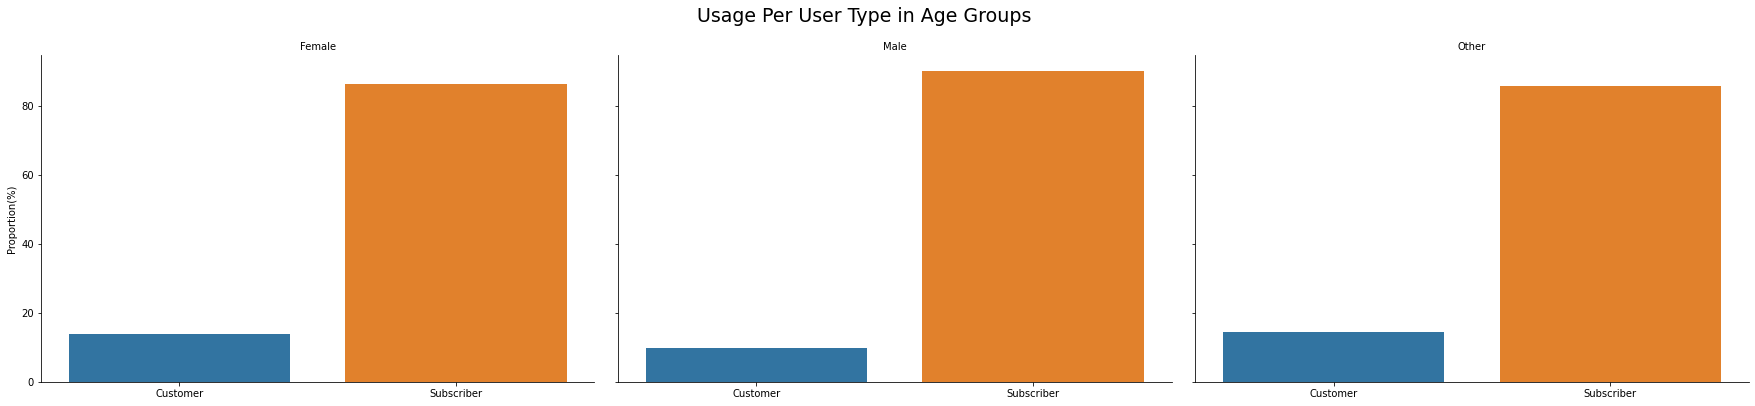

In [43]:
g = sns.catplot(data=type_gender, x='user_type' , y='count', col="gender", kind='bar', height=10 ,aspect=0.5)
g.fig.set_size_inches(25,5)
g.set_axis_labels("", "Proportion(%)")
g.set_titles("{col_name}" , fontsize = 15)
g.fig.suptitle('Usage Per Gender Type in Age Groups ', y=1.1, fontsize=19);

#### Bike rides per Gender & Age

In [44]:
age_gender = df[df.member_gender.isin(["Male","Female"])].groupby(['member_gender' ,'member_age_bins']).size()
age_gender = age_gender.groupby(level=1).apply(lambda x: round(100 * x / x.sum(),1)).reset_index()
age_gender.columns = ['gender' ,'age_bins','prop(%)']
age_gender[age_gender.gender=="Female"]

,gender,age_bins,prop(%)
0,Female,10 - 20,24.7
1,Female,20 - 30,27.5
2,Female,30 - 40,25.4
3,Female,40 - 50,20.2
4,Female,50 - 60,21.6
5,Female,60 - 80,15.0


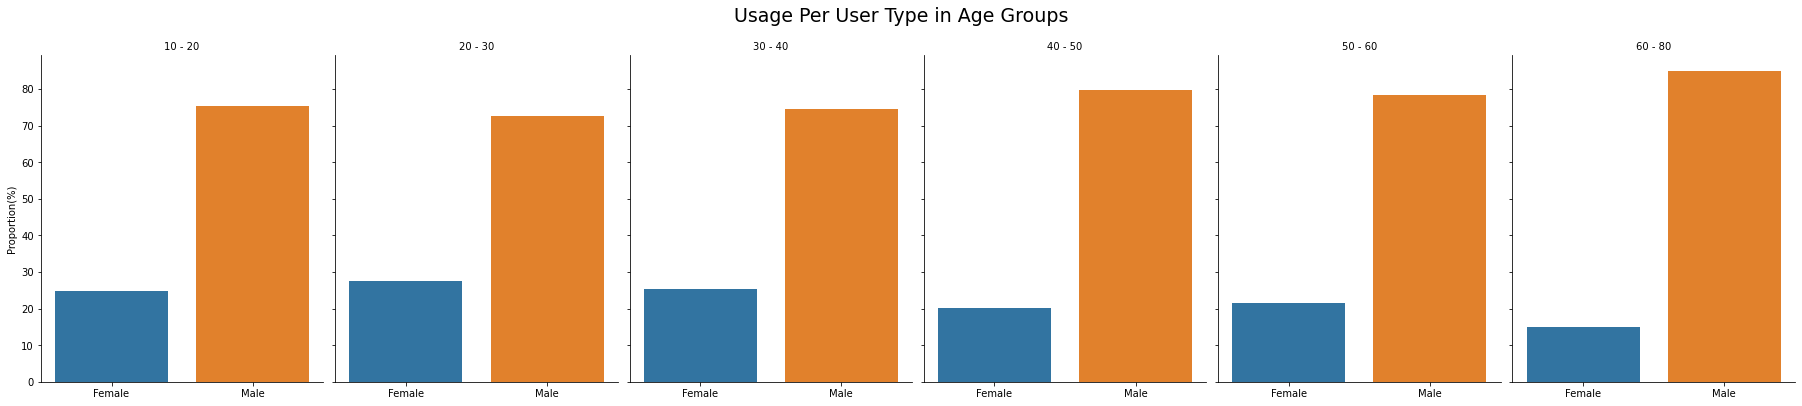

In [45]:
g = sns.catplot(data=age_gender, x='gender' , y='prop(%)', col="age_bins", kind='bar', height=10 ,aspect=0.5)
g.fig.set_size_inches(25,5)
g.set_axis_labels("", "Proportion(%)")
g.set_titles("{col_name}" , fontsize = 15)
g.fig.suptitle('Usage Per User Type in Age Groups ', y=1.1, fontsize=19);

#### Monlthly usage trend Per Age group

Text(0.5, 0.98, 'Monthly Usage Trend by Age groups')

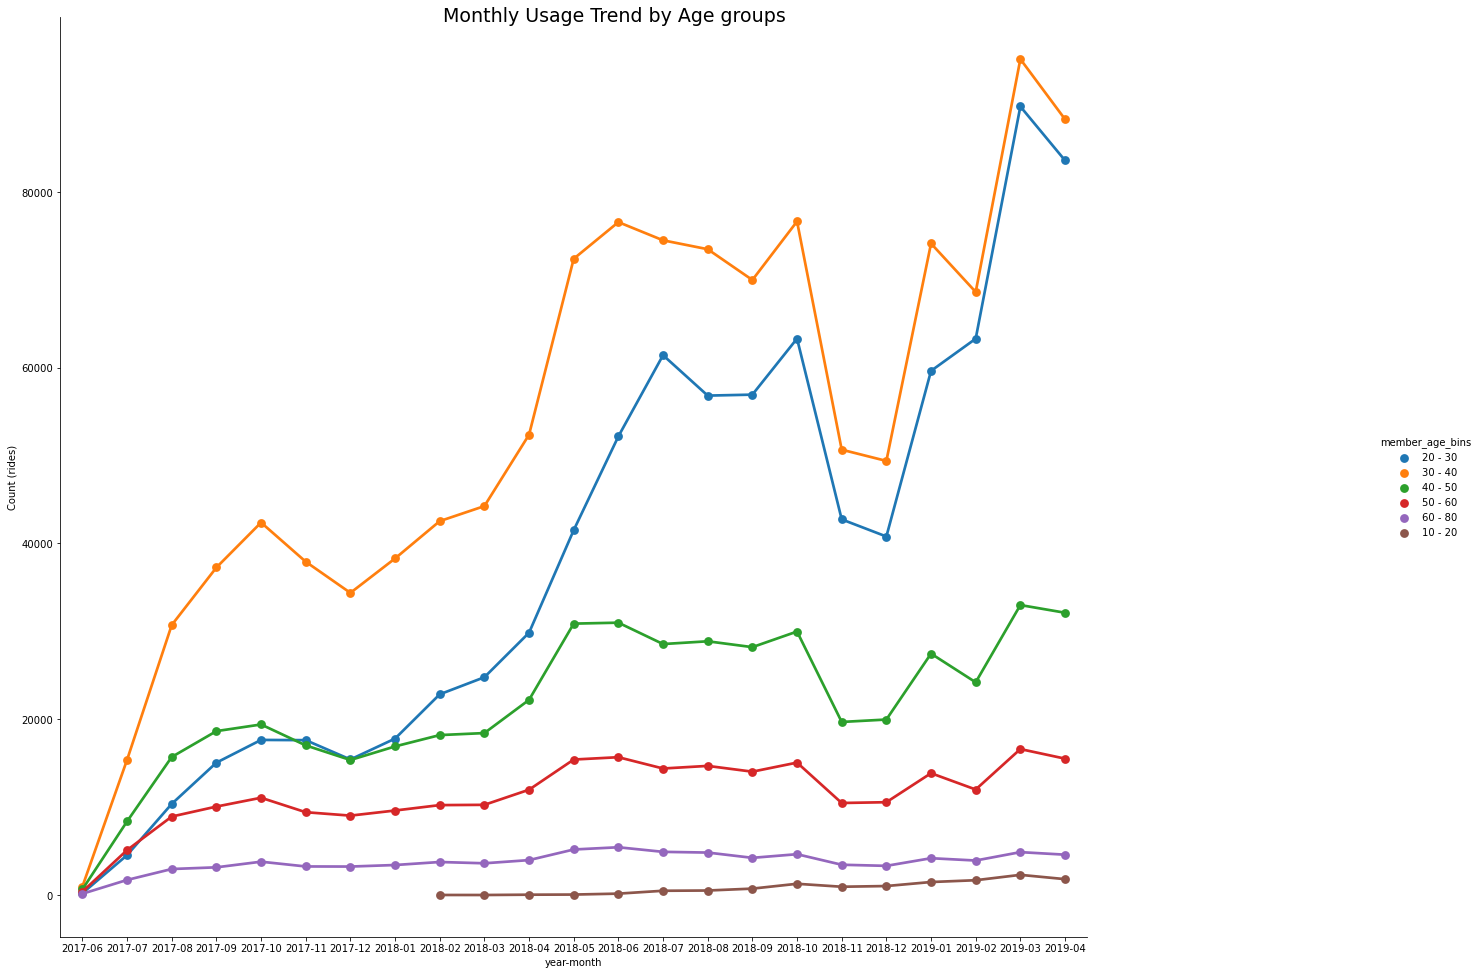

In [46]:
montly_age_group = df.groupby([df.year_month , df['member_age_bins']]).agg({'bike_id':'count'})
montly_age_group = montly_age_group.reset_index()
g = sns.catplot(x='year_month' , y='bike_id', hue='member_age_bins', data=montly_age_group , kind= 'point')
g.fig.set_size_inches(24,15)
g.set_axis_labels("year-month", "Count (rides)")
g.fig.suptitle("Monthly Usage Trend by Age groups" , fontsize = 19)

In case of people whose age from 20 to 40 years old, the usage is going up sharply.

#### Monlthly usage trend Per User type 

Text(0.5, 0.98, 'Monthly Usage Trend by user type')

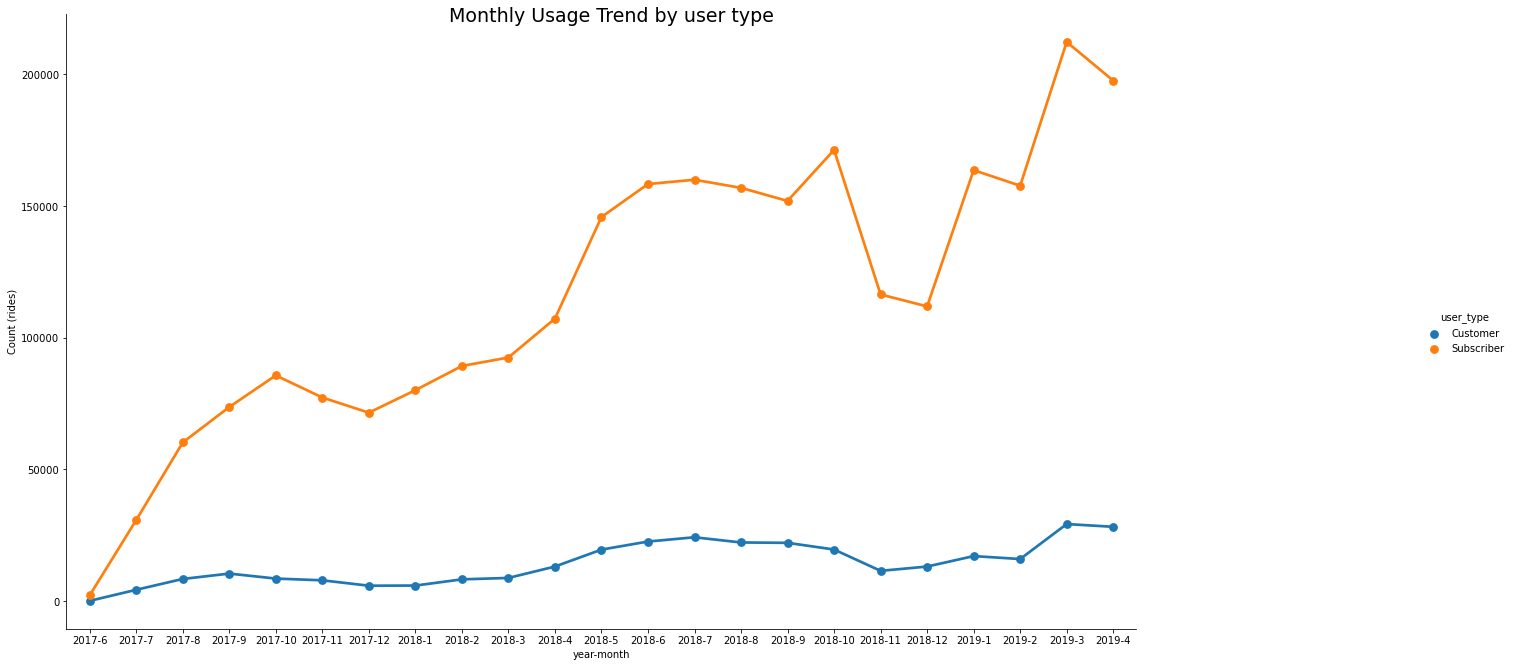

In [47]:
montly_type_group = df.groupby([df['start_time'].dt.year, df['start_time'].dt.month , df['user_type']]).agg({'bike_id':'count'})
montly_type_group.index.rename(['year','month','user_type'] ,inplace = True)
# montly_age_group.index.levels[0].name = 'year'
# montly_age_group.index.levels[1].name = 'month'
montly_type_group = montly_type_group.reset_index()
montly_type_group["time"] = montly_type_group['year'].astype(str) +'-' + montly_type_group['month'].astype(str)

g = sns.catplot(x='time' , y='bike_id', hue='user_type', data=montly_type_group , kind= 'point')
g.set_axis_labels("year-month", "Count (rides)")
g.fig.set_size_inches(25,10)
g.fig.suptitle("Monthly Usage Trend by user type" , fontsize = 19)

The differnce between customer and subscriber had been getting wider since the first month.  
November and December 2018, Subscribers' usage droped sharply contrary to the upward trend unlike the customer's usage show the constrant pattern relatively.

In [48]:
# customer_age_df = df[df['user_type']=='Customer'].groupby(['start_time_year_month', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()
# plt.figure(figsize=(15,8))
# ax = sb.pointplot(x='start_time_year_month', y='bike_id', hue='member_age_bins', 
#                   scale=.6, data=customer_age_df)
# plt.title("2017 monthly trend of bike rides per customers' member age group", fontsize=22, y=1.015)
# plt.xlabel('year-month', labelpad=16)
# plt.ylabel('count [rides]', labelpad=16)
# leg = ax.legend()
# leg.set_title('Member age group',prop={'size':16})
# ax = plt.gca()
# ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
# plt.savefig('pic11.jpg')

In [49]:
df.columns

Index(['bike_id', 'distance_km', 'duration_sec', 'member_gender', 'user_type',
       'member_age', 'start_dow', 'year_month', 'month', 'year', 'start_time',
       'start_station_name', 'member_age_bins'],
      dtype='object')

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?


#### Duration

- Seeing the vilon plot shapes, female's duration is longer than male's overall  , unlike my prejudice that men is usually have better endurance physically so that they bike longer.  
- Duration for customer is longer than subscriber.  


#### Usage

- Customers' usage is higher during the day, not during rush hour  while Subscribers frequently ride bikes during rush hour.  
- Subscriber's weekend usage rate is lower than that of the customer.  
- Feamle and Male have similar weekend usage rates, but Female's is a little higher.  
- Looking at the Montly useage trend, it has been increased steeply between the ages of 20 and 40 and for subscribers.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

- Men's subscriber ratio is 90.1 percent, higher than women's 86.2 percent.  
- The higher the age, the higher the percentage of subscribers.  
- Female ratio is higher than other age group in age between 10 and 40. (20's show the highest : 27.5%).

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

#### Duration Per Gender and Age

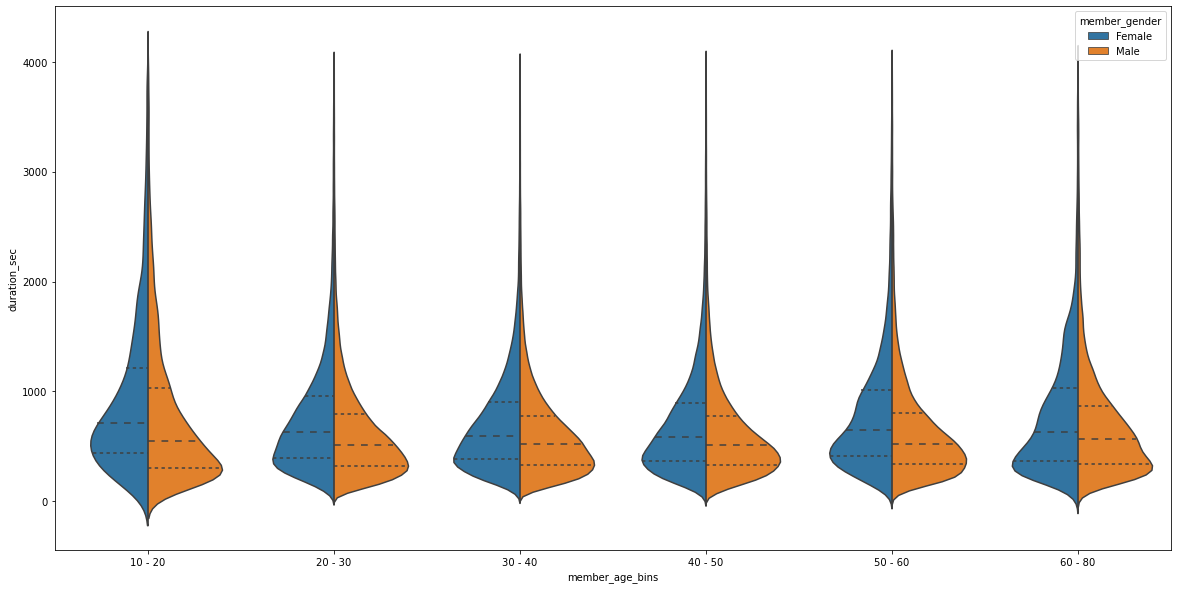

In [51]:
# 바이올린 duration vs gender(man vs woman) vs agebins
plt.subplots(figsize = (20,10))
sns.violinplot(x="member_age_bins", y="duration_sec", hue="member_gender",
               split=True, inner="quart",order = age_order,
               data=df.query("member_gender in ['Male', 'Female']"))


Across all age groups, Female ride bikes longer than male, considering the inner quantile line in vilon plot.  
Especially 10s show the wide gap.

#### Duration Per Gender and Day of week

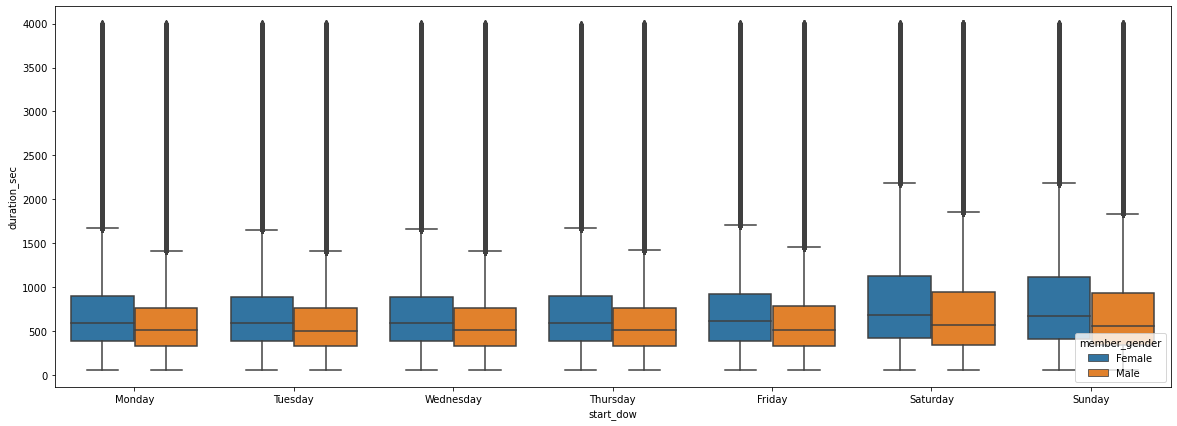

In [52]:
# box duration vs gender(man vs woman) vs dow
plt.subplots(figsize = (20,7))
sns.boxplot(data=df.query("member_gender in ['Male', 'Female']"), x= 'start_dow' , y='duration_sec' ,hue = 'member_gender' ,order = dow_order )

By box's range, both genders have longer durations on weekends than weekdays, but Female show higher durations on weekends than Males.

#### Duration Per User type and Age

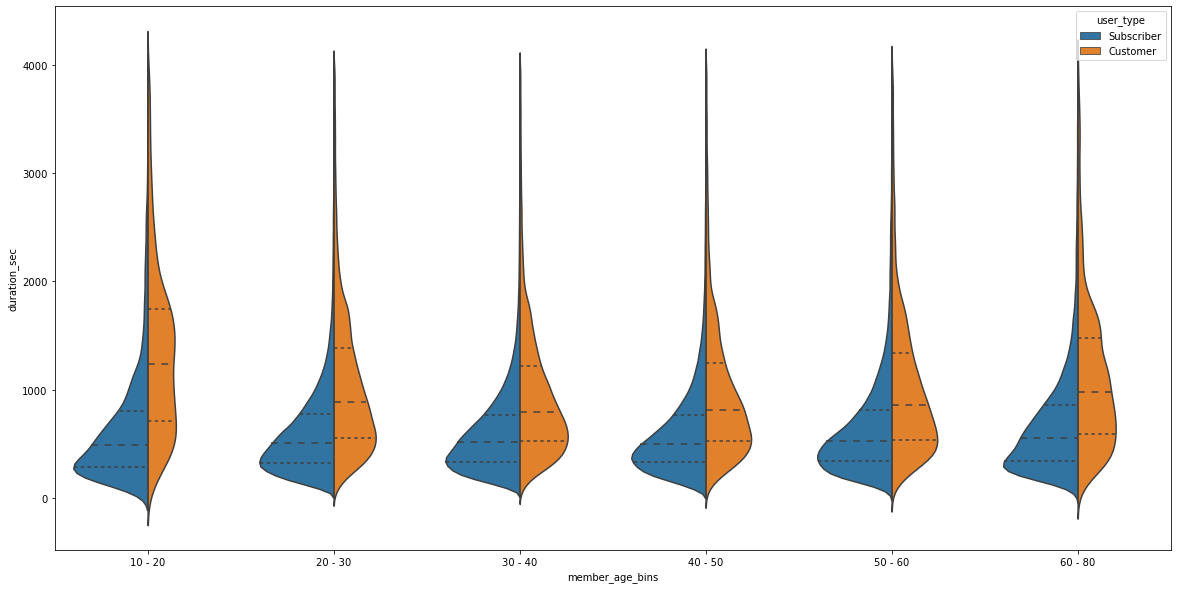

In [53]:
# 바이올린 duration vs customer type vs agebins
plt.subplots(figsize = (20,10))
sns.violinplot(x="member_age_bins", y="duration_sec", hue="user_type",
               split=True, inner="quart",order = age_order, data=df)

Across all age groups, customers ride bikes longer than subscribers. Especially, 10's show the wide gap between gender.

#### Mean Duration per Month and Age

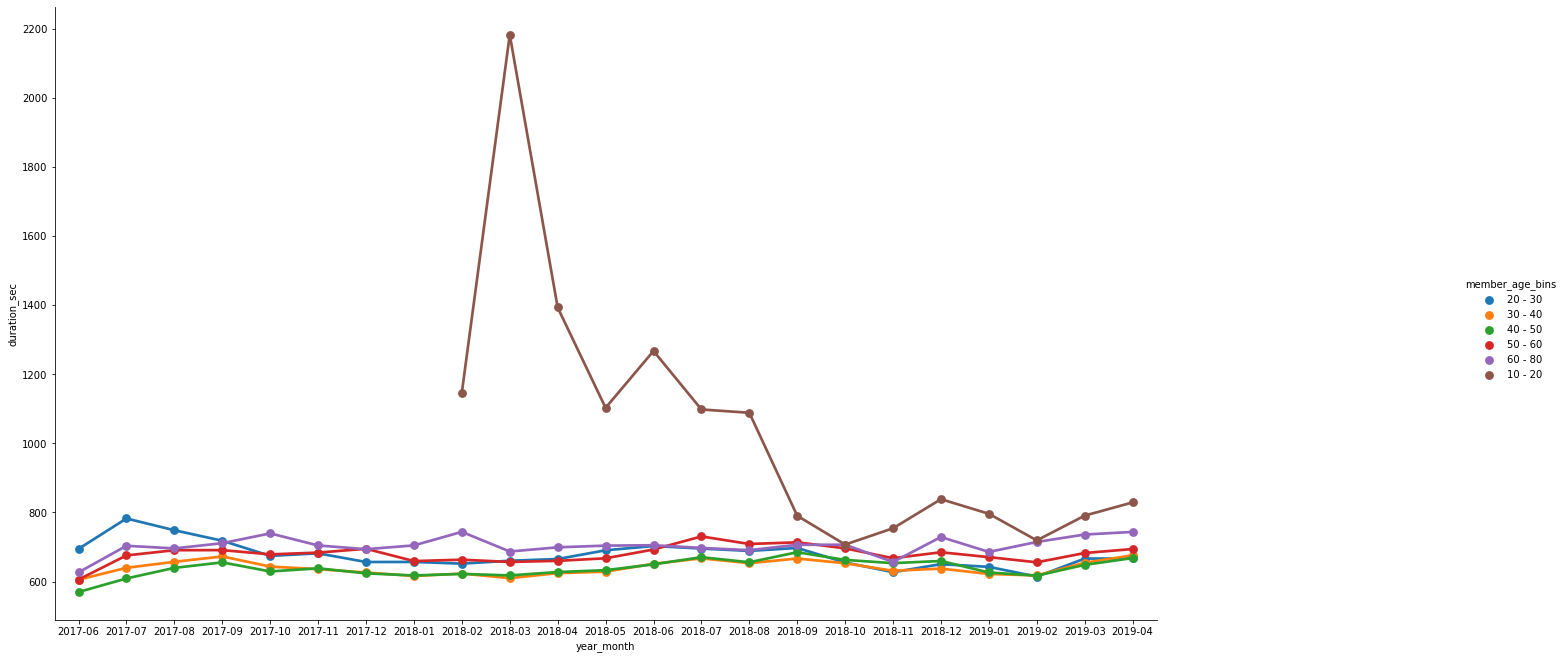

In [54]:
montly_age_duration = df.groupby(['year_month','member_age_bins']).agg({'duration_sec':'mean'})
montly_age_duration = montly_age_duration.reset_index()
g = sns.catplot(x='year_month' , y='duration_sec', hue='member_age_bins', data=montly_age_duration , kind= 'point')
g.fig.set_size_inches(25,10)

in case of 10's , the duration rocket and March 2018 and plunge soon.  
To focus on other ages than 10's, I'll adjust limitation of y-axis.

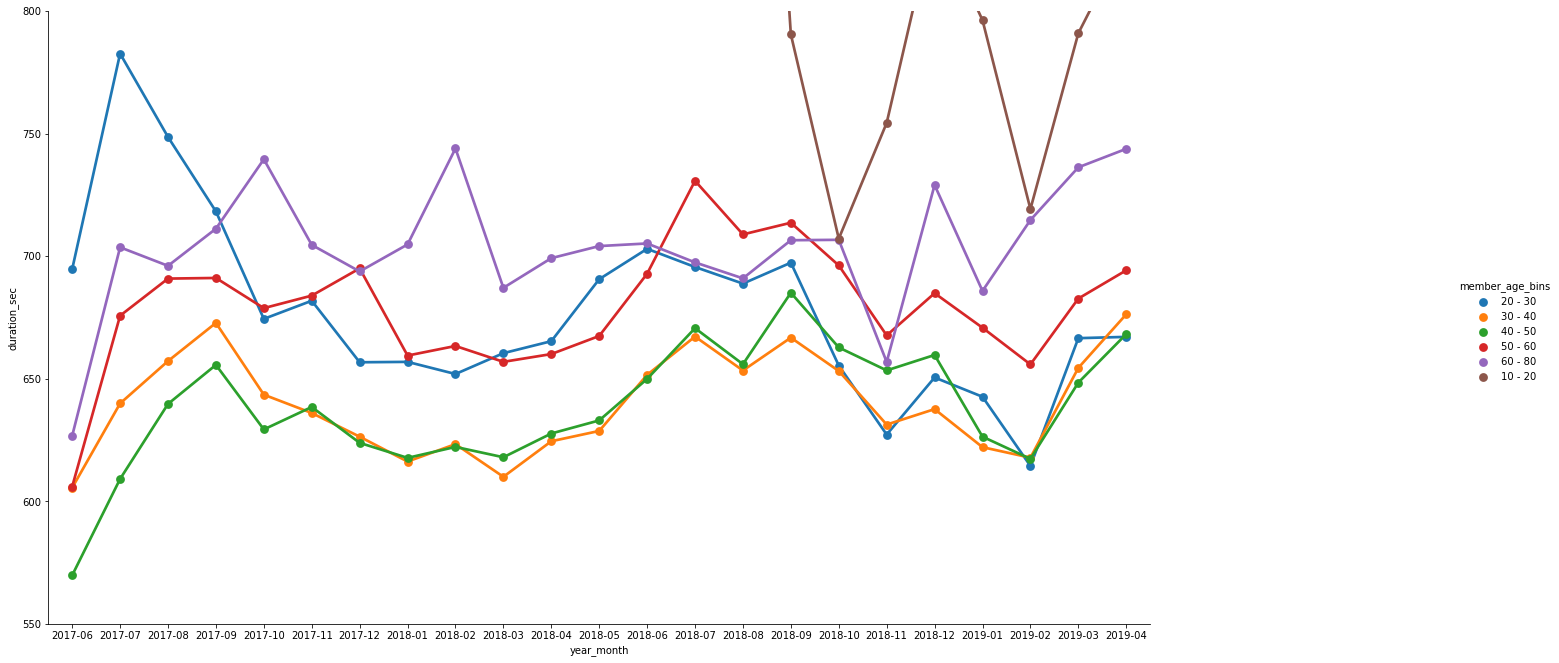

In [55]:
montly_age_duration = df.groupby(['year_month','member_age_bins']).agg({'duration_sec':'mean'})
montly_age_duration = montly_age_duration.reset_index()
g = sns.catplot(x='year_month' , y='duration_sec', hue='member_age_bins', data=montly_age_duration , kind= 'point')
g.set(ylim=(550, 800))
g.fig.set_size_inches(25,10)

All ages show the very simillar pattern except for 10s.  
What's interesting is that people in 20s had the longest duration, but at the end, they were the lowest.

#### Mean Duration per Month and Gender

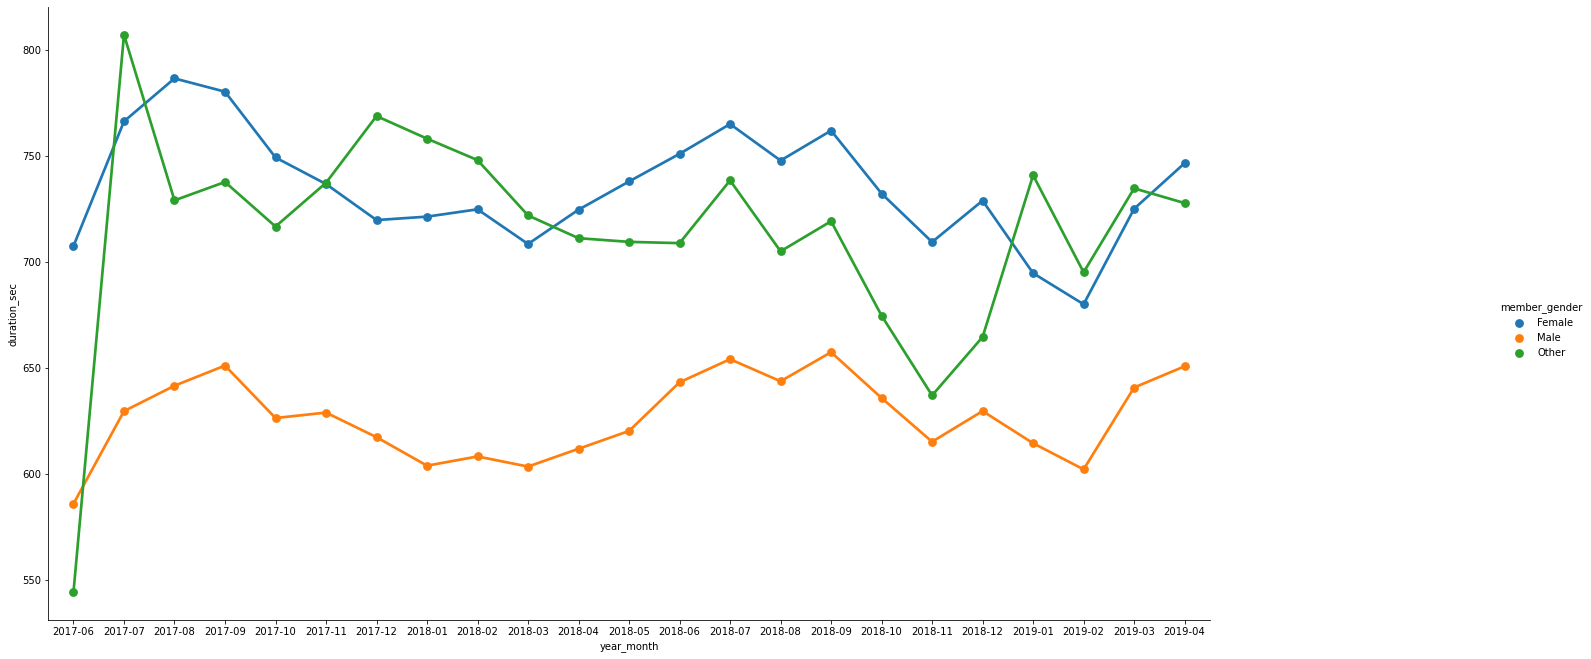

In [56]:
montly_g_duration = df.groupby(['year_month','member_gender']).agg({'duration_sec':'mean'})
montly_g_duration = montly_g_duration.reset_index()
g = sns.catplot(x='year_month' , y='duration_sec', hue='member_gender', data=montly_g_duration , kind= 'point')
g.fig.set_size_inches(25,10)

Also It show the simillar patern just between Feamle and Male.   
But the slope of change of Female is almost always sharper than that of Male. 

#### Mean Duration per Month and User type

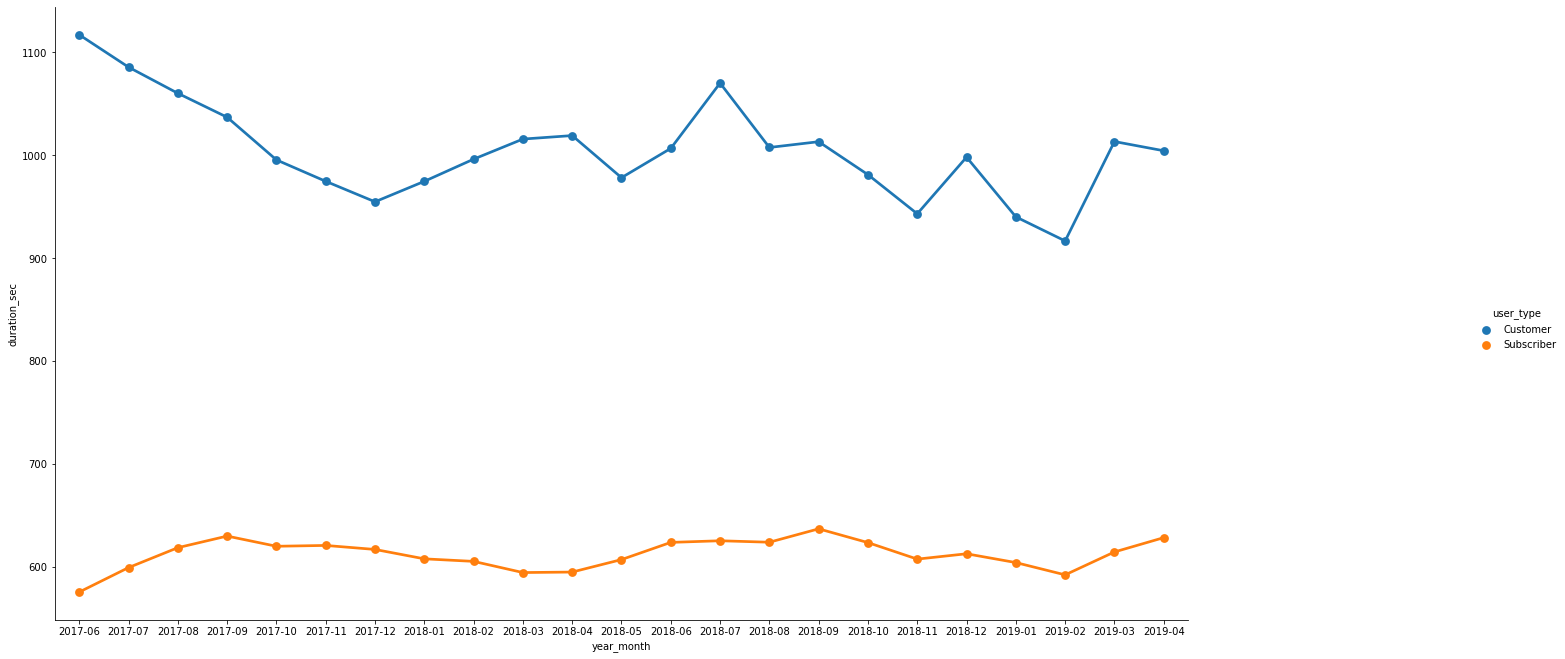

In [57]:
montly_t_duration = df.groupby(['year_month','user_type']).agg({'duration_sec':'mean'})
montly_t_duration = montly_t_duration.reset_index()
g = sns.catplot(x='year_month' , y='duration_sec', hue='user_type', data=montly_t_duration , kind= 'point')
g.fig.set_size_inches(25,10)

#### Mean Duration per Hour and User type

Text(0.5, 1.0, 'Customer Duration Per Hour')

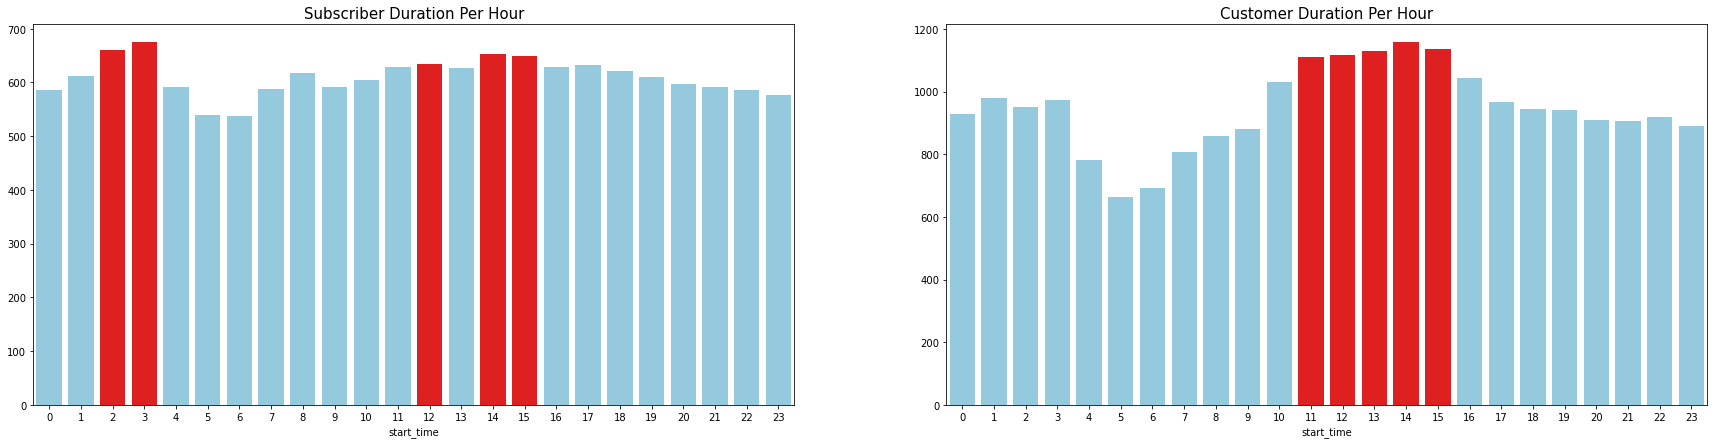

In [74]:
fig,ax = plt.subplots(1,2 , figsize = (30, 7))

temp1 = df.query("user_type == 'Subscriber'")
values = temp1.groupby(temp1.start_time.dt.hour)['duration_sec'].agg('mean')
rank5 = values[values.rank(ascending= False) == 5]
clrs = ['skyblue' if (x < rank5.values) else 'red' for x in values]
sns.barplot(x= values.index, y= values.values , palette=clrs , ax = ax[0])
ax[0].set_title('Subscriber Duration Per Hour' , fontsize = 15)

temp1 = df.query("user_type == 'Customer'")
values = temp1.groupby(temp1.start_time.dt.hour)['duration_sec'].agg('mean')
rank5 = values[values.rank(ascending= False) == 5]
clrs = ['skyblue' if (x < rank5.values) else 'red' for x in values]
sns.barplot(x= values.index, y= values.values , palette=clrs , ax = ax[1])
ax[1].set_title('Customer Duration Per Hour' , fontsize = 15)


The graphs in red show the top5 hour which the users ride bikes in longest time in a day.  
It is surprsing fact that the hour in which subscriber's average trip is longest is 2~3am. 

#### Hourly Usage during Weekdays for Customers and Subscribers

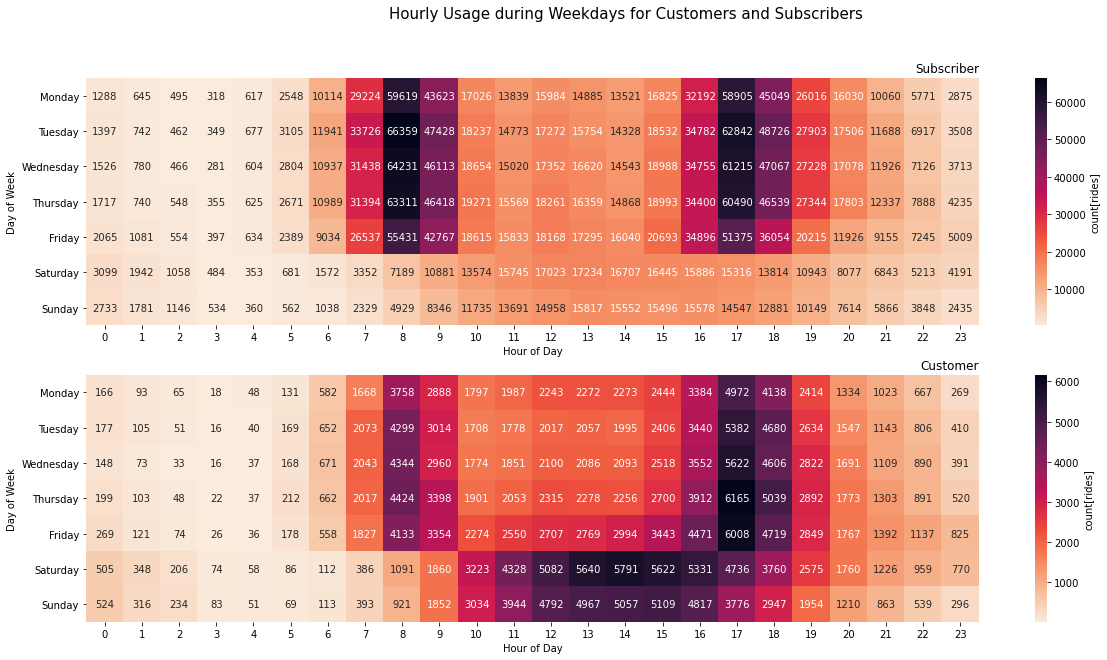

In [121]:

plt.figure(figsize=(20,10))
plt.suptitle('Hourly Usage during Weekdays for Customers and Subscribers' , fontsize=15)

plt.subplot(2, 1, 1)
subscribers = df.query('user_type == "Subscriber"')
st_counts = subscribers.groupby(['start_dow', 'start_hour']).size()
st_counts = st_counts.reset_index(name='count')
st_counts = st_counts.pivot(index='start_dow', columns='start_hour', values='count')
st_counts = st_counts.loc[dow_order,:]
sns.heatmap(st_counts, cmap='rocket_r' , annot = True, fmt = 'd' , cbar_kws = {'label' : 'count[rides]'});
plt.title('Subscriber', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

plt.subplot(2, 1, 2)
customers = df.query('user_type == "Customer"')
ct_counts = customers.groupby(['start_dow', 'start_hour']).size()
ct_counts = ct_counts.reset_index(name='count')
ct_counts = ct_counts.pivot(index='start_dow', columns='start_hour', values='count')
ct_counts = ct_counts.loc[dow_order,:]
sns.heatmap(ct_counts, cmap='rocket_r' , annot = True, fmt = 'd', cbar_kws = {'label' : 'count[rides]'});
plt.title('Customer', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

# sns.heatmap(cat_means, annot = True, fmt = '.3f',
#            cbar_kws = {'label' : 'mean(distance_avg)'});




This hitmap give clear information of difference between the subscribers and customers.  
Subscribers ride bike on work days , Monday to Friday , whereas customers use the service during day on weekends , namely from 11 to 16 on saturday and sunday.

#### Hourly Mean duration during Weekdays for Customers and Subscribers

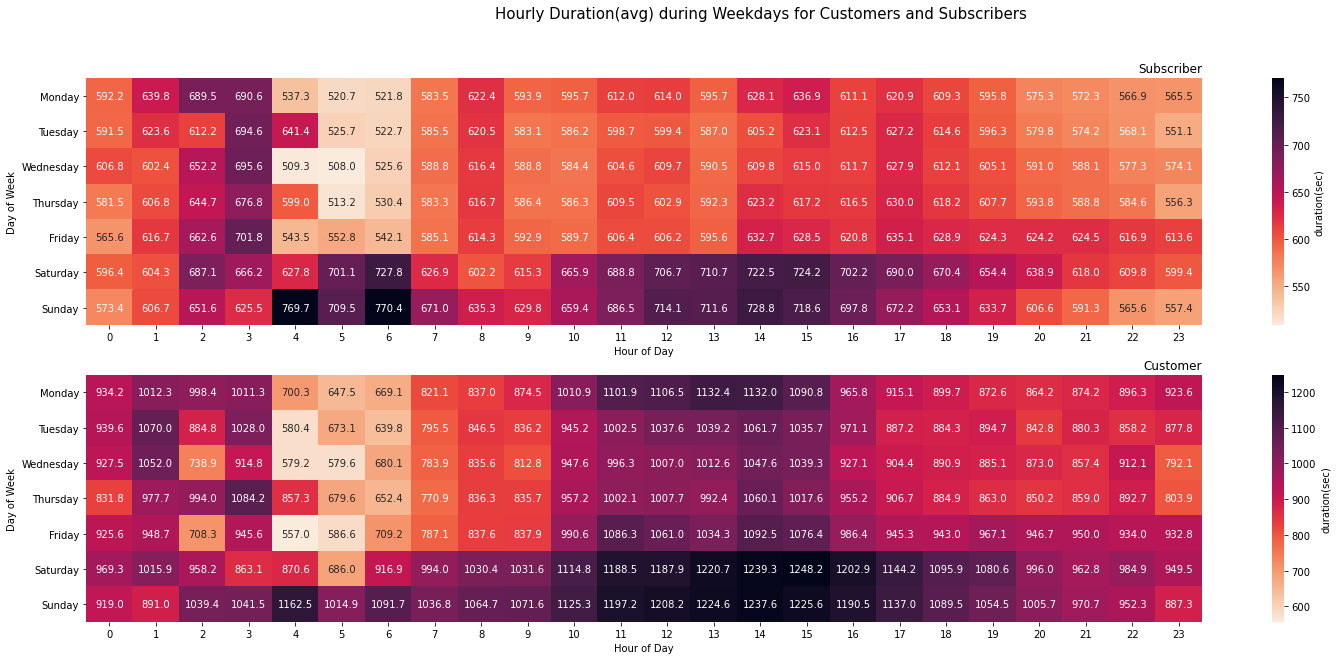

In [125]:

plt.figure(figsize=(25,10))
plt.suptitle('Hourly Duration(avg) during Weekdays for Customers and Subscribers' , fontsize=15)

plt.subplot(2, 1, 1)
subscribers = df.query('user_type == "Subscriber"')
st_mean = subscribers.groupby(['start_dow', 'start_hour'])['duration_sec'].agg('mean')
st_mean = st_mean.reset_index(name='mean_duration')
st_mean = st_mean.pivot(index='start_dow', columns='start_hour', values='mean_duration')
st_mean = st_mean.loc[dow_order,:]
sns.heatmap(st_mean, cmap='rocket_r' , annot = True, fmt = '.1f' , cbar_kws = {'label' : 'duration(sec)'});
plt.title('Subscriber', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

plt.subplot(2, 1, 2)
customers = df.query('user_type == "Customer"')
ct_mean = customers.groupby(['start_dow', 'start_hour'])['duration_sec'].agg('mean')
ct_mean = ct_mean.reset_index(name='mean_duration')
ct_mean = ct_mean.pivot(index='start_dow', columns='start_hour', values='mean_duration')
ct_mean = ct_mean.loc[dow_order,:]
sns.heatmap(ct_mean, cmap='rocket_r' , annot = True, fmt = '.1f', cbar_kws = {'label' : 'duration(sec)'});
plt.title('Customer', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

# sns.heatmap(cat_means, annot = True, fmt = '.3f',
#            cbar_kws = {'label' : 'mean(distance_avg)'});



We saw this patter already above.  
The interesting thing is people remarkbly trip longer at 2am on sunday in case of both customer or subscriber

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?


#### Duration

- Across all age groups, Female ride bikes longer than male. the biggest gap between gender can be found in 10s.
- Subscribers ride bike on work days , Monday to Friday , whereas customers use the service during day on weekends , namely from 11 to 16 on saturday and sunday.
- Monthly trend show similar pattern across all type of user(ie. gender, age and subscriber or customer)

### Were there any interesting or surprising interactions between features?

- It is surprsing fact that the hour in which subscriber's average trip is longest is 2~3am.
- The interesting thing is people remarkbly trip longer at 2am on sunday in case of both customer or subscriber.
- What's interesting is that people in 20s showed the longest duration in the beginning of this observation, but at the end, they were the lowest.

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!